# FX Trend Following Strategies: SMA Crossover, Time-Series Momentum, and EWMA Vol-Normalised Crossover

## Abstract

This notebook implements and analyses three classical trend-following strategies applied to a universe of FX spot rates spanning December 2005 to March 2020. The strategies progress from elementary to sophisticated:

1. **Simple Moving Average (SMA) Crossover** — a price-level signal that goes long (short) when a fast moving average exceeds (falls below) a slow moving average.
2. **Time-Series Momentum (TSMOM)** — a return-based signal that takes a position in the direction of the rolling mean of past log returns.
3. **EWMA Vol-Normalised Crossover** — a multi-window exponentially weighted crossover computed on a volatility-adjusted synthetic spot, with inverse-volatility position scaling.

All three strategies are evaluated on a single-pair basis (EURUSD) and then aggregated into an equal-weight multi-currency portfolio across eight G10 pairs.

---

## Table of Contents

1. [Background: Trend Following in FX](#section-1)
2. [SMA Crossover Strategy](#section-2)
3. [Return-Based Momentum: TSMOM and EWMA Vol-Normalised Crossover](#section-3)
4. [Multi-Currency Portfolio Analysis](#section-4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    'figure.figsize':    (12, 5),
    'axes.spines.top':   False,
    'axes.spines.right': False,
    'axes.grid':         True,
    'grid.alpha':        0.3,
    'font.size':         11,
})

PALETTE = ['#1F77B4', '#D62728', '#2CA02C', '#FF7F0E', '#9467BD']

In [3]:
project_root = os.path.abspath('../..')
sys.path.insert(0, project_root)
print('Project root:', project_root)

assert project_root.endswith('RiskAlphaEngine'), (
    f'Unexpected root: {project_root} — check notebook location.'
)

DATA_PATH = os.path.join(project_root, 'data', 'spots_currencies_universe.csv')
assert os.path.exists(DATA_PATH), f'Data file not found: {DATA_PATH}'
print('Data path verified:', DATA_PATH)

from FX_strategies.sma_backtest import SMAVectorBacktester
from FX_strategies.momentum_backtest import MomVectorBacktester
from FX_strategies.crossover_momentum import Strategy
from FX_strategies.ewma_crossover_backtest import EWMACrossoverBacktester
print('Imports successful.')

Project root: /Users/anacontreras/Documents/Projects/RiskAlphaEngine
Data path verified: /Users/anacontreras/Documents/Projects/RiskAlphaEngine/data/spots_currencies_universe.csv
Imports successful.


<a id="section-1"></a>
## 1. Background: Trend Following in FX

Trend following is the systematic exploitation of serial autocorrelation (momentum) in asset prices: if returns exhibit positive autocorrelation at medium-term horizons, a strategy that bets in the direction of recent price moves will earn a positive expected return.

**Empirical evidence.** Moskowitz, Ooi, and Pedersen (2012) document time-series momentum across 58 liquid futures markets — equities, bonds, currencies, and commodities — and show that past 12-month returns are positively predictive of next-month returns. In FX specifically, Menkhoff, Sarno, Schmeling, and Schrimpf (2012) demonstrate that currency momentum is robust to transaction costs, subperiods, and risk adjustments.

**Why FX trends persist.** Several structural forces sustain momentum in currency markets:
- Central bank intervention tends to smooth rather than reverse trends, allowing misalignments to persist;
- Carry-motivated capital flows create self-reinforcing directional moves;
- Slow information diffusion across heterogeneous market participants generates delayed price discovery.

**Strategy taxonomy.** The three strategies in this notebook differ in their signal construction:

| Strategy | Signal Input | Position Rule | Vol-Scaling |
|---|---|---|---|
| SMA Crossover | Price levels | $\text{sign}(\text{SMA}_{n_1} - \text{SMA}_{n_2})$ | None |
| TSMOM | Log returns | $\text{sign}(\bar{r}_t^{(m)})$ | None |
| EWMA Vol-Normalised | Returns / vol | Multi-window EWMA average | Inverse volatility |

In [4]:
raw = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True, dayfirst=True).dropna()
raw.index = pd.to_datetime(raw.index, dayfirst=True)

print(f'Shape:      {raw.shape}')
print(f'Date range: {raw.index[0].date()} to {raw.index[-1].date()}')
print(f'Pairs ({len(raw.columns)}):  {list(raw.columns)}')
raw.head(3)

Shape:      (3726, 28)
Date range: 2005-12-12 to 2020-03-26
Pairs (28):  ['AUDUSD', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDBRL', 'USDCAD', 'USDCHF', 'USDCLP', 'USDCNH', 'USDCNY', 'USDCZK', 'USDHKD', 'USDHUF', 'USDIDR', 'USDILS', 'USDINR', 'USDJPY', 'USDKRW', 'USDMXN', 'USDMYR', 'USDNOK', 'USDPLN', 'USDRUB', 'USDSEK', 'USDSGD', 'USDTRY', 'USDTWD', 'USDZAR']


AUDUSD  EURUSD  GBPUSD  NZDUSD  USDBRL  USDCAD  USDCHF  USDCLP  \
date                                                                         
2005-12-12  0.7560  1.1974  1.7763  0.7116  2.2595  1.1520  1.2872  510.65   
2005-12-13  0.7550  1.1935  1.7677  0.7073  2.2653  1.1519  1.2940  511.25   
2005-12-14  0.7555  1.2019  1.7726  0.7061  2.2805  1.1517  1.2815  516.25   

            USDCNH  USDCNY  ...   USDMXN  USDMYR  USDNOK  USDPLN   USDRUB  \
date                        ...                                             
2005-12-12  8.0770  8.0770  ...  10.6263   3.776  6.6428  3.1916  28.7025   
2005-12-13  8.0751  8.0751  ...  10.6422   3.775  6.6537  3.2154  28.7370   
2005-12-14  8.0746  8.0746  ...  10.7096   3.779  6.6036  3.1948  28.6629   

            USDSEK  USDSGD  USDTRY  USDTWD  USDZAR  
date                                                
2005-12-12  7.8755  1.6800  1.3483  33.552  6.3245  
2005-12-13  7.9081  1.6746  1.3482  33.495  6.2888  
2005-12-14  7.8432  1.6697  1.3495  33.361  6.3405  

[3 rows x 28 columns]

In [5]:
raw.describe().round(4)

AUDUSD     EURUSD     GBPUSD     NZDUSD     USDBRL     USDCAD  \
count  3726.0000  3726.0000  3726.0000  3726.0000  3726.0000  3726.0000   
mean      0.8396     1.2685     1.5670     0.7248     2.5642     1.1529   
std       0.1203     0.1287     0.2224     0.0741     0.8273     0.1329   
min       0.5786     1.0384     1.1555     0.4938     1.5371     0.9181   
25%       0.7431     1.1381     1.3900     0.6736     1.8578     1.0272   
50%       0.8006     1.2812     1.5625     0.7201     2.2247     1.1236   
75%       0.9315     1.3602     1.6552     0.7825     3.2516     1.2944   
max       1.1013     1.5990     2.1102     0.8814     5.1600     1.4577   

          USDCHF     USDCLP     USDCNH     USDCNY  ...     USDMXN     USDMYR  \
count  3726.0000  3726.0000  3726.0000  3726.0000  ...  3726.0000  3726.0000   
mean      1.0172   575.4868     6.7545     6.7536  ...    14.5552     3.6016   
std       0.1096    85.2693     0.5179     0.5180  ...     3.2435     0.4410   
min       0.7300   431.4500     6.0193     6.0409  ...     9.8928     2.9490   
25%       0.9461   505.3050     6.3406     6.3386  ...    12.2467     3.2030   
50%       0.9882   546.0650     6.7242     6.7180  ...    13.2028     3.5076   
75%       1.0646   651.9175     6.9016     6.8974  ...    18.2384     4.0702   
max       1.3216   873.2500     8.0775     8.0775  ...    25.0596     4.5080   

          USDNOK     USDPLN     USDRUB     USDSEK     USDSGD     USDTRY  \
count  3726.0000  3726.0000  3726.0000  3726.0000  3726.0000  3726.0000   
mean      6.8684     3.2881    42.1178     7.6019     1.3729     2.5274   
std       1.2442     0.4706    16.5689     1.0481     0.1016     1.4212   
min       4.9470     2.0285    23.1399     5.8490     1.2019     1.1512   
25%       5.8509     2.9759    28.9470     6.6797     1.2845     1.5115   
50%       6.3156     3.2230    32.3212     7.3002     1.3637     1.8298   
75%       8.1784     3.7360    60.8388     8.4741     1.4201     3.0286   
max      11.7564     4.2898    82.2878    10.4005     1.6800     7.0062   

          USDTWD     USDZAR  
count  3726.0000  3726.0000  
mean     31.1283    10.2312  
std       1.3393     2.9948  
min      28.5500     5.9733  
25%      30.0222     7.4542  
50%      30.8805     9.7736  
75%      32.3448    13.2786  
max      35.1650    17.6554  

[8 rows x 28 columns]

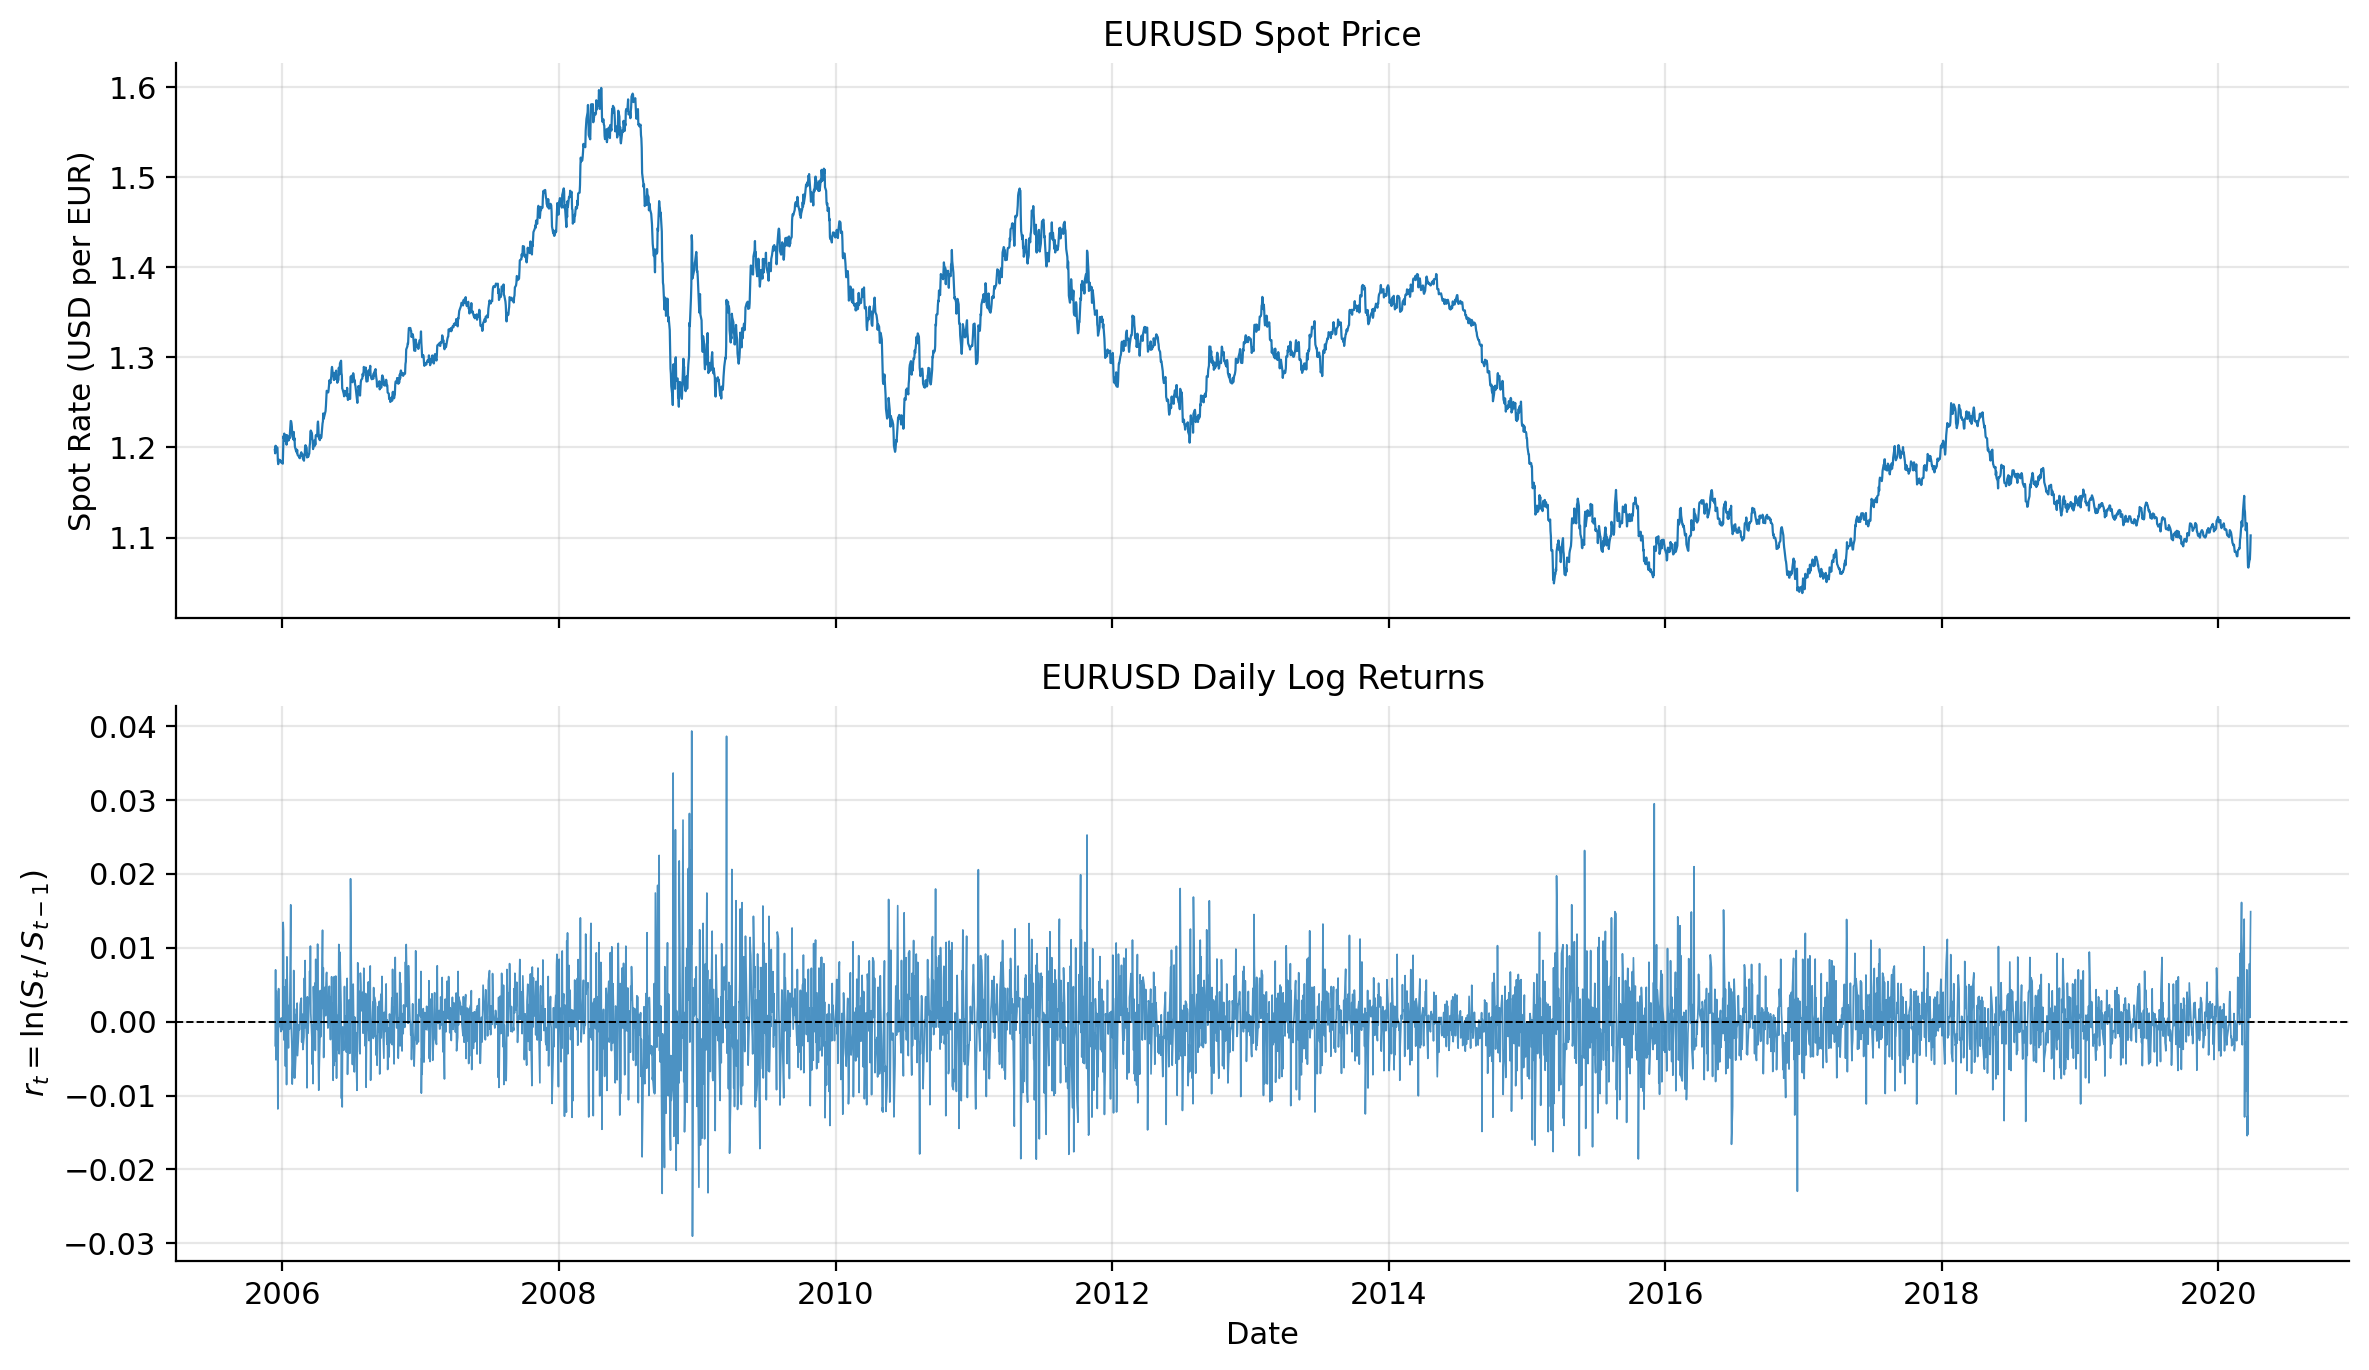

In [6]:
log_returns = np.log(raw / raw.shift(1)).dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

axes[0].plot(raw['EURUSD'], color=PALETTE[0], linewidth=0.8)
axes[0].set_title('EURUSD Spot Price', fontsize=12)
axes[0].set_ylabel('Spot Rate (USD per EUR)')

axes[1].plot(log_returns['EURUSD'], color=PALETTE[0], linewidth=0.6, alpha=0.8)
axes[1].axhline(0, color='black', linewidth=0.7, linestyle='--')
axes[1].set_title('EURUSD Daily Log Returns', fontsize=12)
axes[1].set_ylabel(r'$r_t = \ln(S_t\,/\,S_{t-1})$')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

### 1.1 Serial Autocorrelation in FX Returns

Trend-following strategies are profitable precisely when returns exhibit positive serial autocorrelation at the horizon over which the signal is defined. The sample autocorrelation at lag $k$ is:

$$\hat{\rho}_k = \frac{\displaystyle\sum_{t=k+1}^{T}(r_t - \bar{r})(r_{t-k} - \bar{r})}{\displaystyle\sum_{t=1}^{T}(r_t - \bar{r})^2}$$

At lag 1, FX daily returns are close to white noise — consistent with short-horizon efficiency. At medium-term horizons (20–250 trading days), positive autocorrelation is documented empirically. The ACF plot below checks for this structure in EURUSD and provides the empirical motivation for the strategies in Sections 2–3.

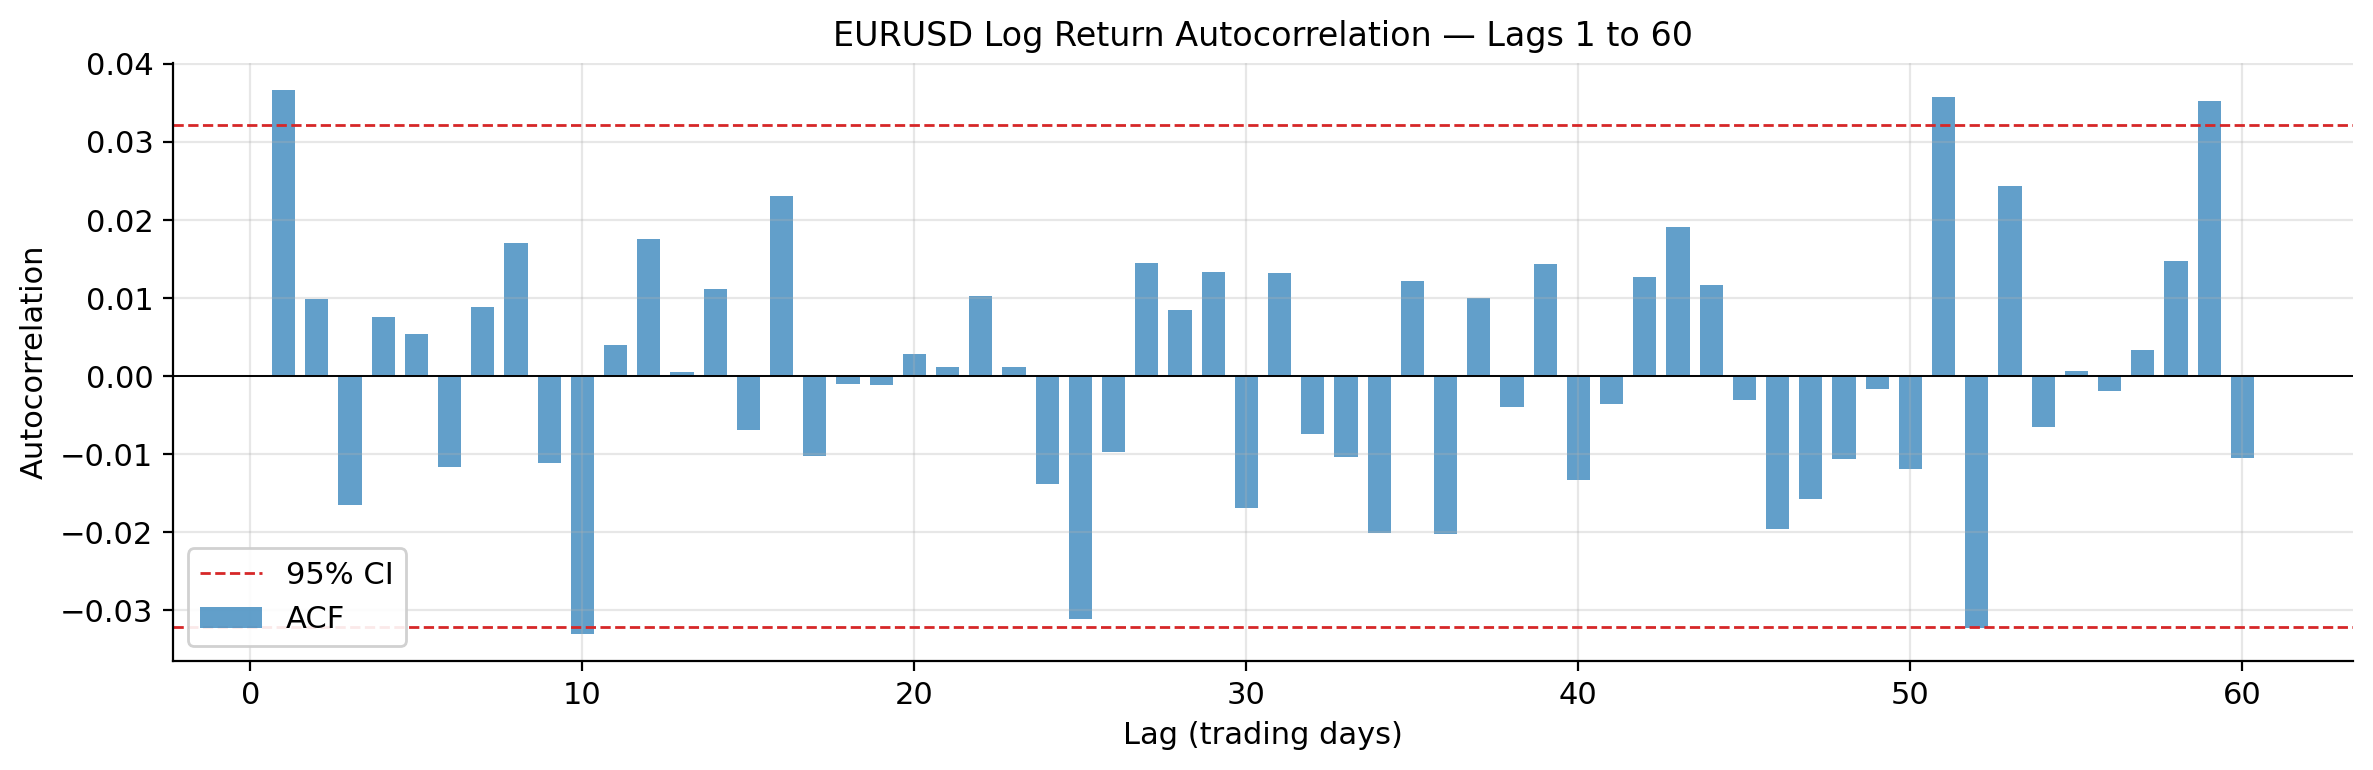

In [7]:
from statsmodels.tsa.stattools import acf

n_lags = 60
r = log_returns['EURUSD'].dropna()
acf_vals, confint = acf(r, nlags=n_lags, alpha=0.05)
ci_hw = confint[1:, 1] - acf_vals[1:]

fig, ax = plt.subplots(figsize=(12, 4))
lags = np.arange(1, n_lags + 1)
ax.bar(lags, acf_vals[1:], color=PALETTE[0], alpha=0.7, width=0.7, label='ACF')
ax.axhline( ci_hw[0], color=PALETTE[1], linestyle='--', linewidth=1.0, label='95% CI')
ax.axhline(-ci_hw[0], color=PALETTE[1], linestyle='--', linewidth=1.0)
ax.axhline(0, color='black', linewidth=0.7)
ax.set_title('EURUSD Log Return Autocorrelation — Lags 1 to 60', fontsize=12)
ax.set_xlabel('Lag (trading days)')
ax.set_ylabel('Autocorrelation')
ax.legend(framealpha=0.9)
plt.tight_layout()
plt.show()

<a id="section-2"></a>
## 2. SMA Crossover Strategy

The SMA crossover rule is one of the oldest and most widely used trend-following rules. It requires no statistical estimation beyond a rolling mean and is easy to interpret: when a fast-moving average rises above a slow-moving average, the instrument is in an uptrend and the strategy goes long.

### 2.0 Mathematical Specification

Let $S_t$ denote the spot price at day $t$ and $r_t = \ln(S_t / S_{t-1})$ the daily log return. Define two simple moving averages with windows $n_1 < n_2$:

$$\text{SMA}_t^{(n)} = \frac{1}{n} \sum_{k=0}^{n-1} S_{t-k}$$

The crossover signal is the spread between the two averages:

$$\delta_t = \text{SMA}_t^{(n_1)} - \text{SMA}_t^{(n_2)}$$

The position takes a binary long or short value:

$$p_t = \text{sign}(\delta_t) = \begin{cases} +1 & \delta_t > 0 \\[4pt] -1 & \delta_t < 0 \end{cases}$$

The daily strategy return is applied with a one-day execution lag to prevent look-ahead bias:

$$\pi_t = p_{t-1} \cdot r_t$$

Gross cumulative performance (rebased to 1.0 at inception) is:

$$\Pi_T = \exp\!\left(\sum_{t=1}^{T} \pi_t\right)$$

In [8]:
sma_eur = SMAVectorBacktester(
    symbol='EURUSD', SMA1=42, SMA2=252,
    start='12-12-2005', end='03-24-2020',
    data_path=DATA_PATH,
)
aperf, operf = sma_eur.run_strategy()
print(f'Gross cumulative performance:   {aperf:.4f}x')
print(f'Out/underperformance vs BnH:    {operf:+.4f}x')
sma_eur.results.tail()

Gross cumulative performance:   1.4000x
Out/underperformance vs BnH:    +0.5800x


price    return      SMA1      SMA2  position  strategy  \
date                                                                   
2020-03-18  1.0848 -0.012823  1.101948  1.112155        -1  0.012823   
2020-03-19  1.0684 -0.015233  1.100976  1.111951        -1  0.015233   
2020-03-20  1.0667 -0.001592  1.099979  1.111722        -1  0.001592   
2020-03-23  1.0751  0.007844  1.099264  1.111537        -1 -0.007844   
2020-03-24  1.0757  0.000558  1.098621  1.111355        -1 -0.000558   

            creturns  cstrategy  
date                             
2020-03-18  0.824441   1.384301  
2020-03-19  0.811978   1.405550  
2020-03-20  0.810686   1.407790  
2020-03-23  0.817069   1.396791  
2020-03-24  0.817525   1.396012

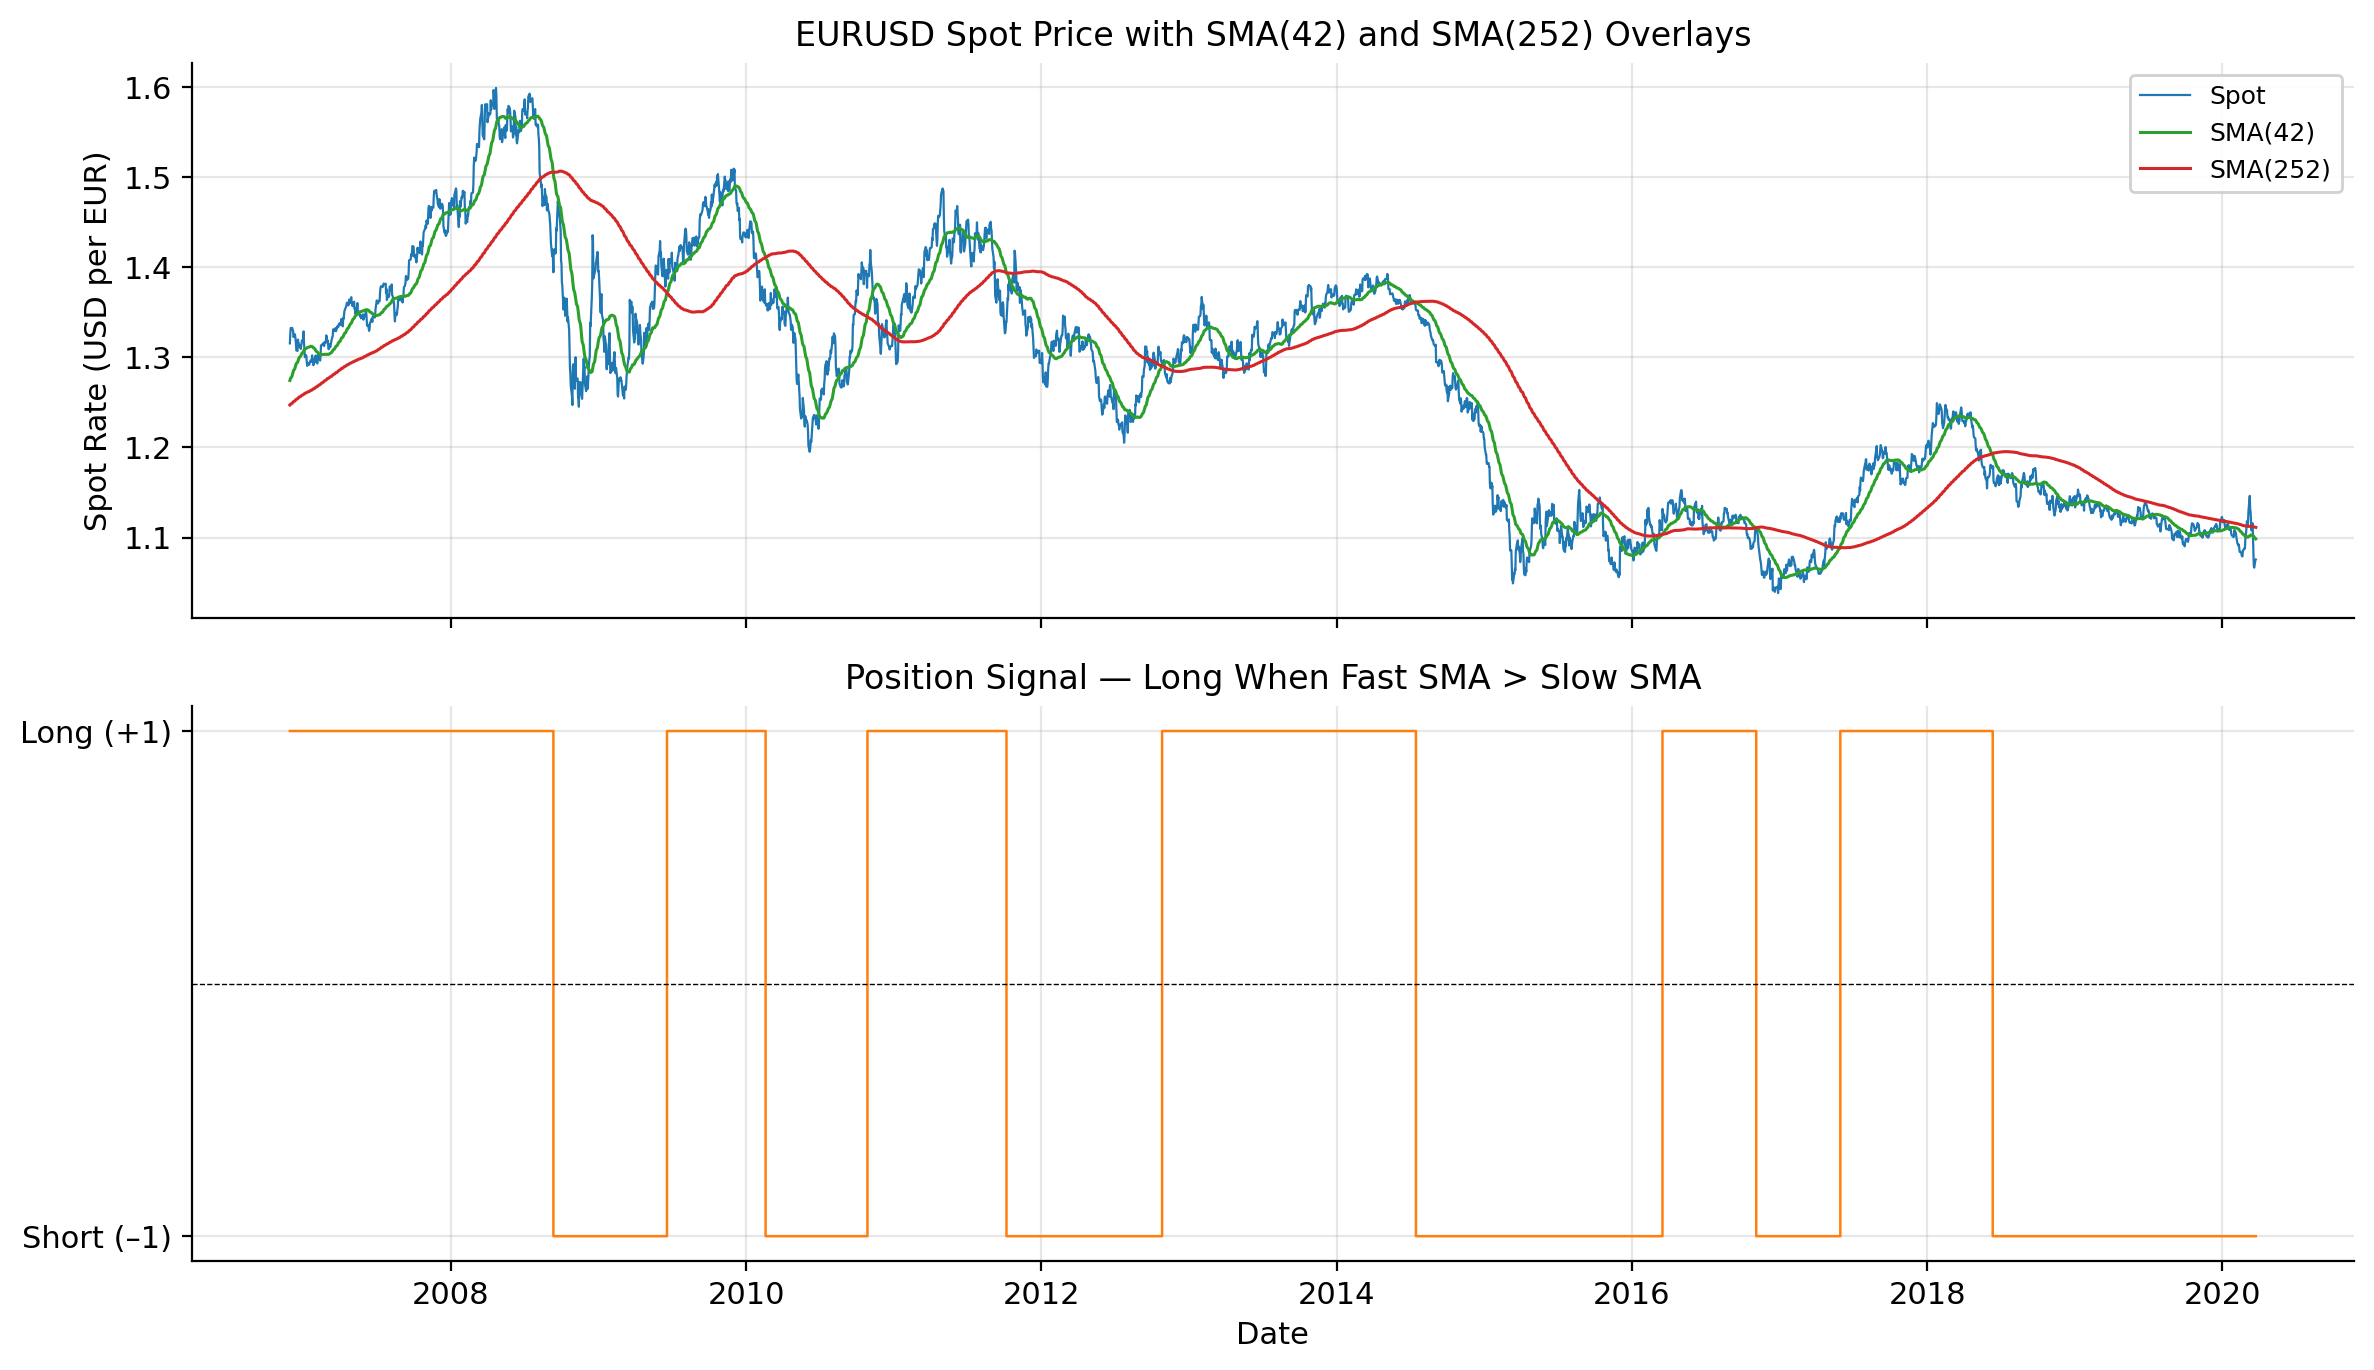

In [9]:
data = sma_eur.results

fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
axes[0].plot(data['price'], color=PALETTE[0], linewidth=0.8, label='Spot')
axes[0].plot(data['SMA1'],  color=PALETTE[2], linewidth=1.1, label=f'SMA({sma_eur.SMA1})')
axes[0].plot(data['SMA2'],  color=PALETTE[1], linewidth=1.1, label=f'SMA({sma_eur.SMA2})')
axes[0].set_title(f'EURUSD Spot Price with SMA({sma_eur.SMA1}) and SMA({sma_eur.SMA2}) Overlays', fontsize=12)
axes[0].set_ylabel('Spot Rate (USD per EUR)')
axes[0].legend(fontsize=9, framealpha=0.9)

axes[1].step(data.index, data['position'], color=PALETTE[3], linewidth=0.9, where='post')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='--')
axes[1].set_yticks([-1, 1])
axes[1].set_yticklabels(['Short (–1)', 'Long (+1)'])
axes[1].set_title('Position Signal — Long When Fast SMA > Slow SMA', fontsize=12)
axes[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

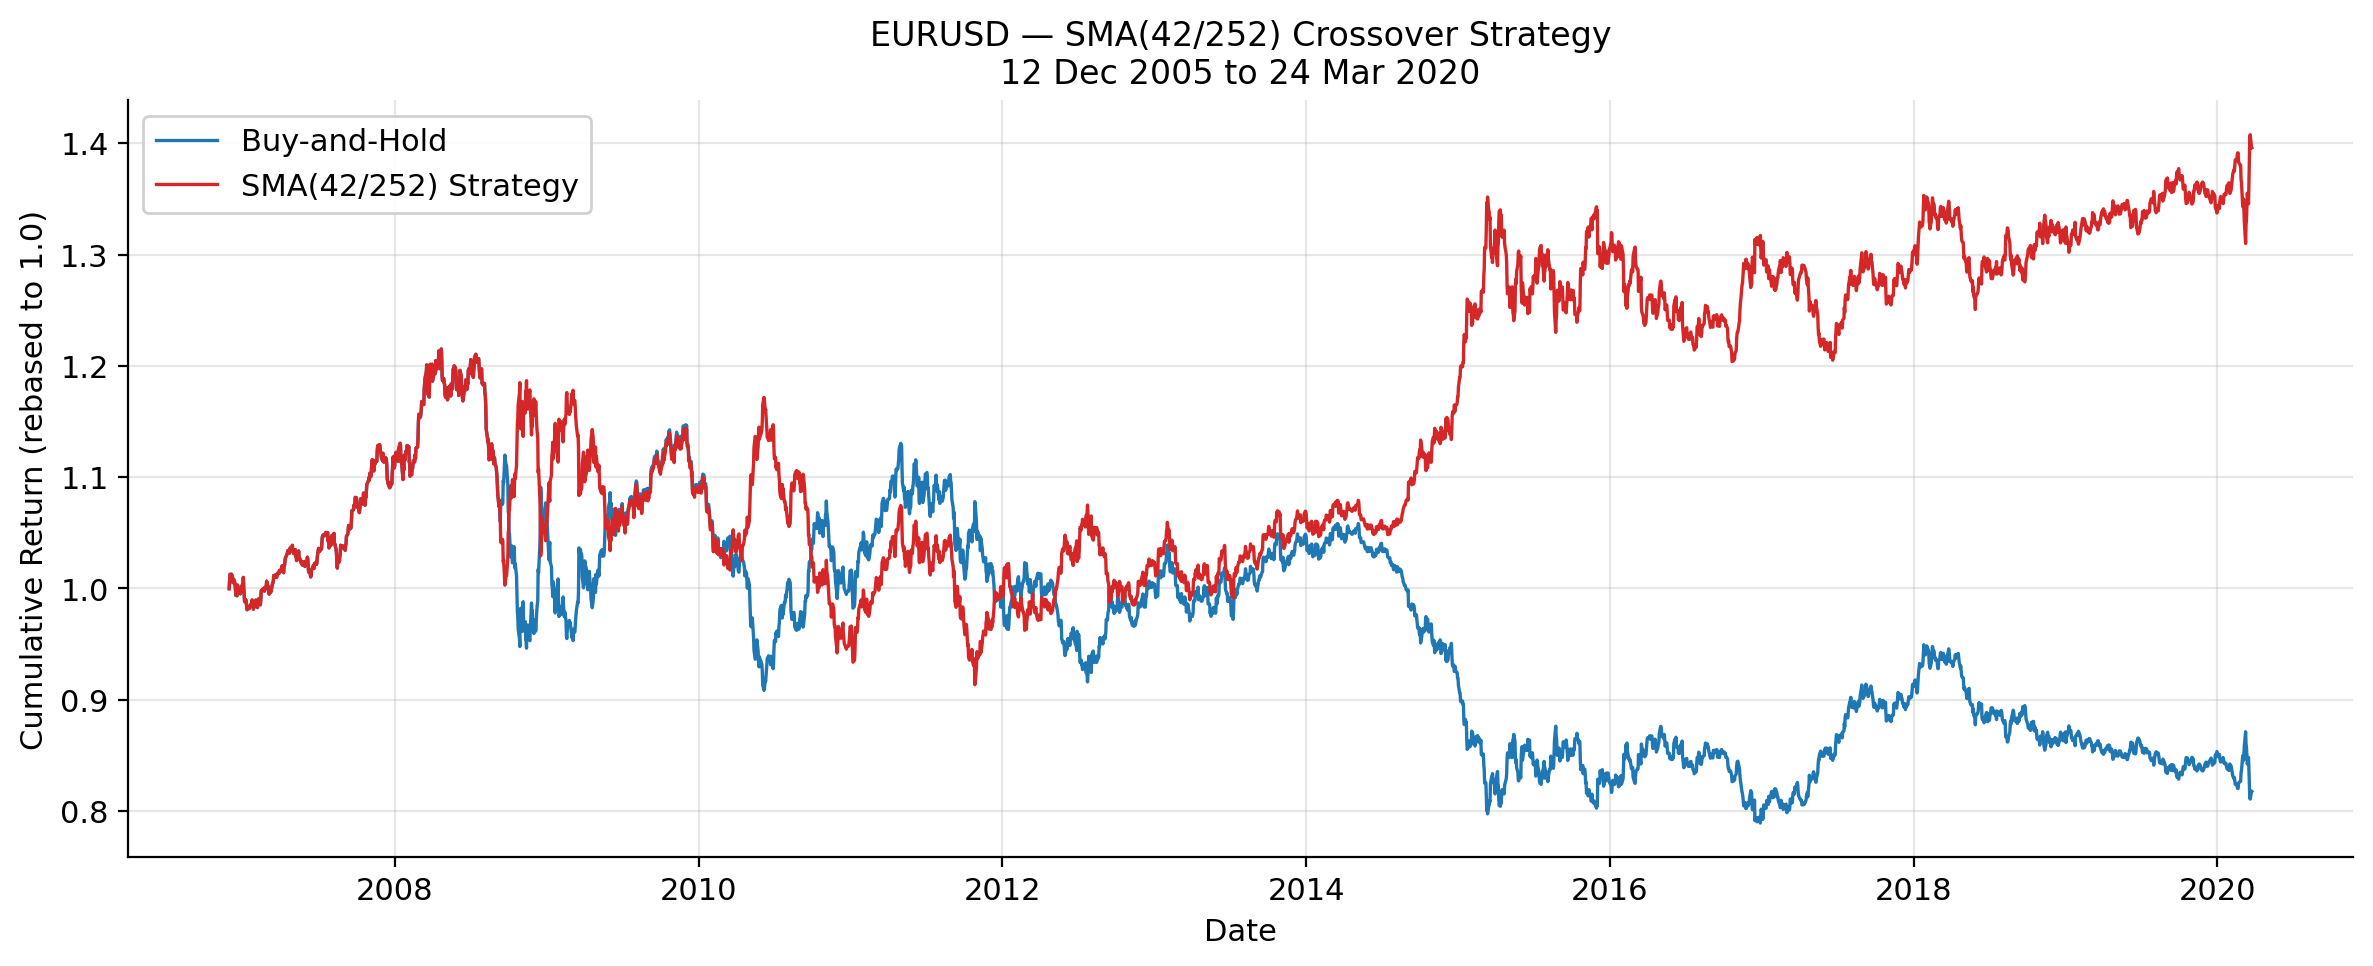

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data['creturns'],  color=PALETTE[0], linewidth=1.2, label='Buy-and-Hold')
ax.plot(data['cstrategy'], color=PALETTE[1], linewidth=1.2, label=f'SMA({sma_eur.SMA1}/{sma_eur.SMA2}) Strategy')
ax.set_title(f'EURUSD — SMA({sma_eur.SMA1}/{sma_eur.SMA2}) Crossover Strategy\n12 Dec 2005 to 24 Mar 2020', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (rebased to 1.0)')
ax.legend(framealpha=0.9)
plt.tight_layout()
plt.show()

In [11]:
def get_summary_stats(results, label='Strategy', trading_days=252):
    """
    Compute annualised performance statistics from a backtester results DataFrame.

    Parameters
    ----------
    results : pd.DataFrame
        Must contain 'return' (benchmark log returns) and 'strategy' (active log returns).
    label : str
        Row label for the strategy in the output table.
    trading_days : int
        Number of trading days per year used for annualisation.

    Returns
    -------
    pd.DataFrame
        Columns: Ann. Return | Ann. Volatility | Sharpe Ratio | Max Drawdown
    """
    rows = {}
    for row_label, col in [('Buy-and-Hold', 'return'), (label, 'strategy')]:
        r       = results[col].dropna()
        ann_ret = r.mean() * trading_days
        ann_vol = r.std()  * np.sqrt(trading_days)
        sharpe  = ann_ret / ann_vol if ann_vol > 0 else np.nan
        cum     = r.cumsum()
        max_dd  = (cum - cum.cummax()).min()
        rows[row_label] = {
            'Ann. Return':     round(ann_ret, 4),
            'Ann. Volatility': round(ann_vol, 4),
            'Sharpe Ratio':    round(sharpe,  4),
            'Max Drawdown':    round(max_dd,  4),
        }
    return pd.DataFrame(rows).T


sma_eur_stats = get_summary_stats(sma_eur.results, label=f'SMA({sma_eur.SMA1}/{sma_eur.SMA2})')
sma_eur_stats

Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown
Buy-and-Hold      -0.0146           0.0901       -0.1624       -0.4317
SMA(42/252)        0.0242           0.0901        0.2689       -0.2855

### 2.1 Parameter Sensitivity and Optimisation

The in-sample optimal parameters solve:

$$\underset{(n_1,\, n_2)}{\arg\max}\; \Pi_T(n_1, n_2) \quad \text{subject to} \quad n_1 < n_2$$

The optimisation below uses `scipy.optimize.brute` to exhaustively evaluate a discrete grid. The result is a **descriptive** characterisation of the parameter landscape, not a prediction of out-of-sample performance.

In [12]:
sma_opt = SMAVectorBacktester(
    symbol='EURUSD', SMA1=42, SMA2=252,
    start='12-12-2005', end='03-24-2020',
    data_path=DATA_PATH,
)
opt_params, opt_perf = sma_opt.optimize_parameters(
    SMA1_range=(10, 80, 5),
    SMA2_range=(100, 300, 10),
)
opt_n1, opt_n2 = int(opt_params[0]), int(opt_params[1])
print(f'Optimal SMA1:               {opt_n1} days')
print(f'Optimal SMA2:               {opt_n2} days')
print(f'Optimal gross performance:  {opt_perf:.4f}x')
print(f'Baseline gross performance: {aperf:.4f}x')

Optimal SMA1:               30 days
Optimal SMA2:               120 days
Optimal gross performance:  2.1100x
Baseline gross performance: 1.4000x


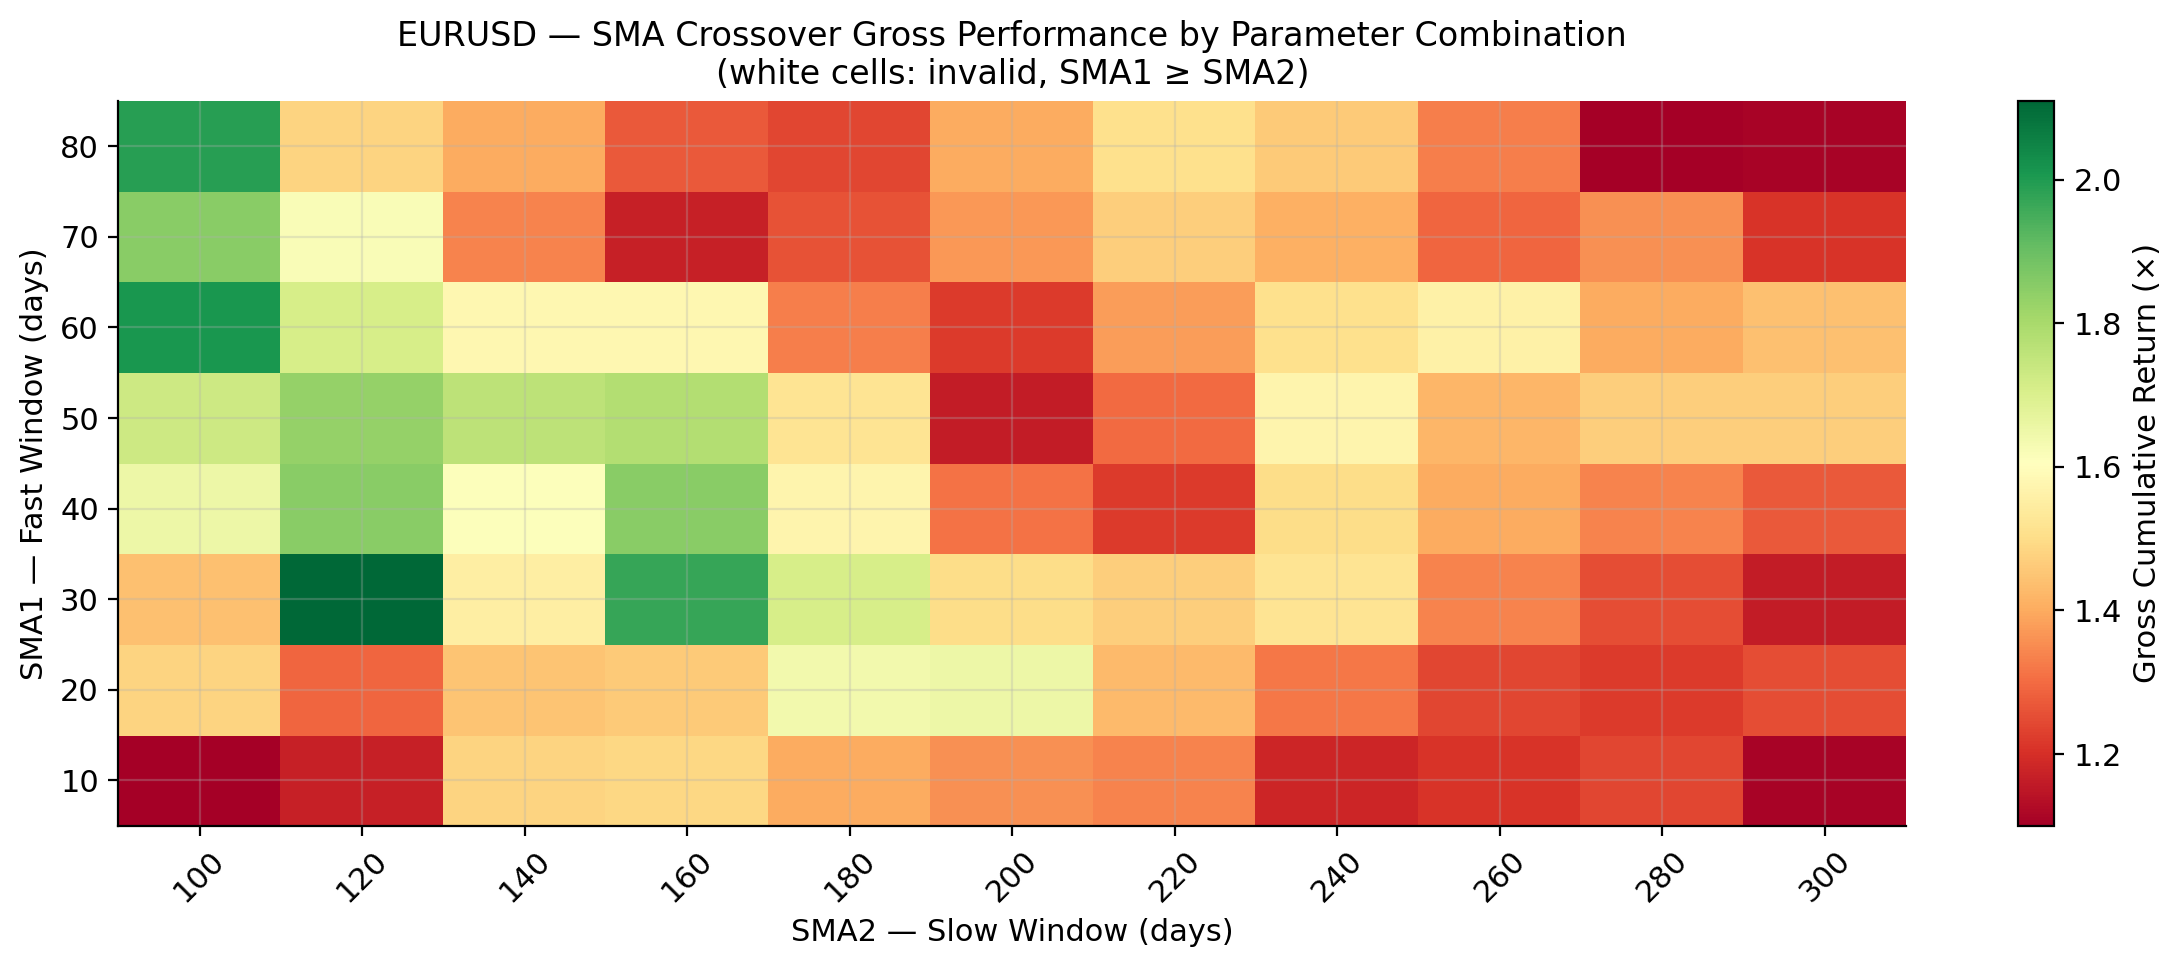

In [13]:
SMA1_vals = list(range(10, 81, 10))
SMA2_vals = list(range(100, 301, 20))
perf_matrix = np.full((len(SMA1_vals), len(SMA2_vals)), np.nan)

sma_grid = SMAVectorBacktester('EURUSD', 10, 100, '12-12-2005', '03-24-2020', data_path=DATA_PATH)
for i, s1 in enumerate(SMA1_vals):
    for j, s2 in enumerate(SMA2_vals):
        if s1 < s2:
            sma_grid.set_parameters(SMA1=s1, SMA2=s2)
            perf_matrix[i, j] = sma_grid.run_strategy()[0]

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(perf_matrix, aspect='auto', origin='lower', cmap='RdYlGn',
               vmin=np.nanmin(perf_matrix), vmax=np.nanmax(perf_matrix))
ax.set_xticks(range(len(SMA2_vals)))
ax.set_xticklabels(SMA2_vals, rotation=45)
ax.set_yticks(range(len(SMA1_vals)))
ax.set_yticklabels(SMA1_vals)
ax.set_xlabel('SMA2 — Slow Window (days)')
ax.set_ylabel('SMA1 — Fast Window (days)')
ax.set_title('EURUSD — SMA Crossover Gross Performance by Parameter Combination\n(white cells: invalid, SMA1 ≥ SMA2)', fontsize=12)
plt.colorbar(im, ax=ax, label='Gross Cumulative Return (×)')
plt.tight_layout()
plt.show()

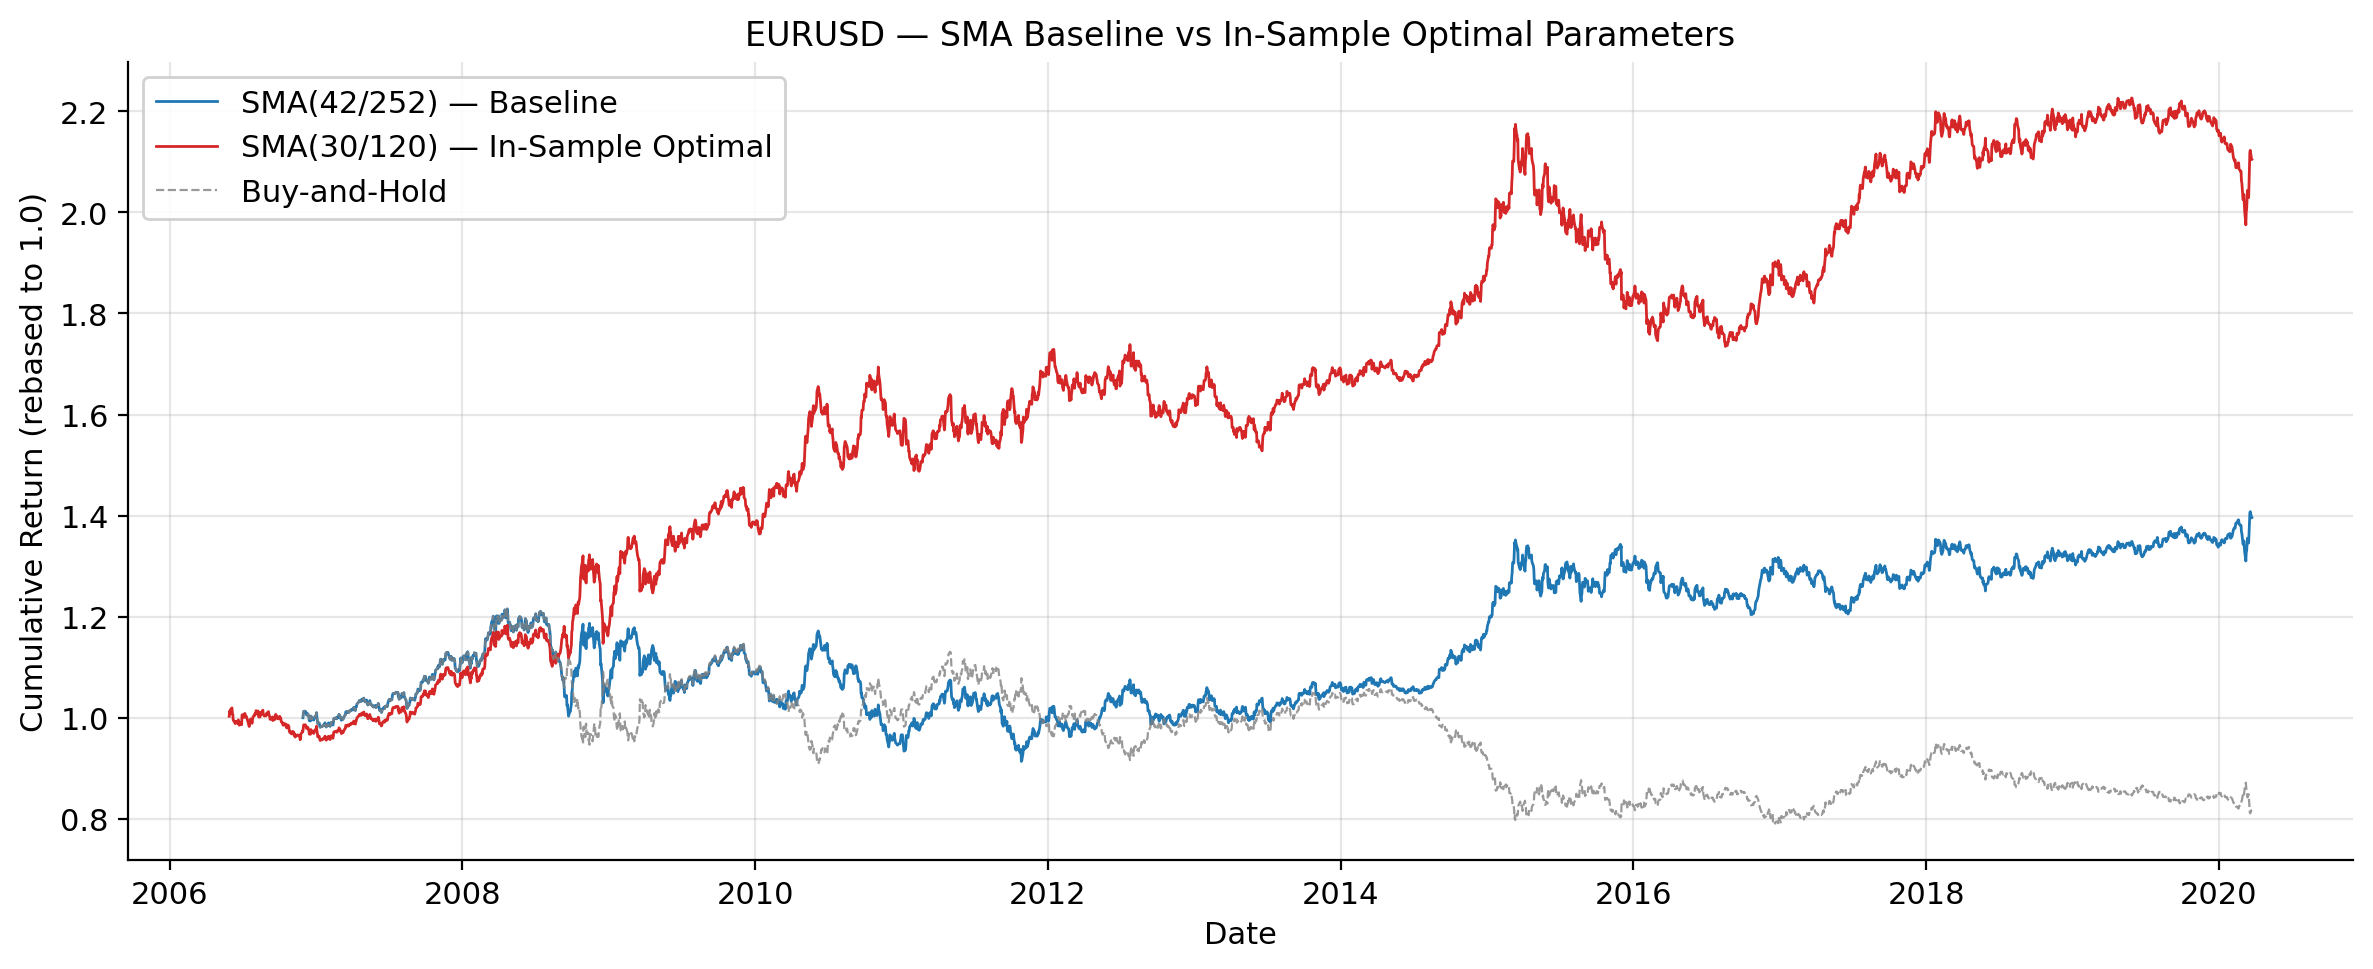


Optimal parameter summary:


Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown
Buy-and-Hold      -0.0117           0.0895       -0.1308       -0.4317
SMA(30/120)        0.0521           0.0894        0.5820       -0.2258

In [14]:
sma_best = SMAVectorBacktester('EURUSD', opt_n1, opt_n2, '12-12-2005', '03-24-2020', data_path=DATA_PATH)
sma_best.run_strategy()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sma_eur.results['cstrategy'],  color=PALETTE[0], linewidth=1.0, label=f'SMA({sma_eur.SMA1}/{sma_eur.SMA2}) — Baseline')
ax.plot(sma_best.results['cstrategy'], color=PALETTE[1], linewidth=1.0, label=f'SMA({opt_n1}/{opt_n2}) — In-Sample Optimal')
ax.plot(sma_eur.results['creturns'],   color='gray',     linewidth=0.8, linestyle='--', label='Buy-and-Hold', alpha=0.8)
ax.set_title('EURUSD — SMA Baseline vs In-Sample Optimal Parameters', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (rebased to 1.0)')
ax.legend(framealpha=0.9)
plt.tight_layout()
plt.show()

print('\nOptimal parameter summary:')
get_summary_stats(sma_best.results, label=f'SMA({opt_n1}/{opt_n2})')

### 2.2 Interpretation and Limitations

**Performance drivers.** The strategy performs well in periods of sustained directional trends — most notably the USD weakening cycle of 2007–2008 and the sharp EUR depreciation from 2014 driven by ECB quantitative easing diverging from the Fed's tightening path.

**Limitations:**
1. No transaction costs — every crossover is a full reversal.
2. Price-level signal — not scale-invariant across pairs.
3. Binary positioning — equal unit size regardless of volatility regime.
4. In-sample optimisation — optimal parameters cannot be used to predict out-of-sample performance without walk-forward validation.

<a id="section-3"></a>
## 3. Return-Based Momentum Strategies

The SMA crossover in Section 2 operates on **price levels**. The two strategies in this section operate directly on **returns**, which are scale-invariant and connect naturally to the academic momentum literature.

---

### 3.1 Time-Series Momentum (TSMOM)

The TSMOM signal at day $t$ with look-back window $m$ is defined as the sign of the mean log return over the preceding $m$ days:

$$\bar{r}_t^{(m)} = \frac{1}{m} \sum_{k=1}^{m} r_{t-k+1}$$

$$p_t = \text{sign}\!\left(\bar{r}_t^{(m)}\right) = \begin{cases} +1 & \bar{r}_t^{(m)} > 0 \\ -1 & \text{otherwise} \end{cases}$$

The daily strategy return, with a one-day execution lag and optional transaction cost $\tau$ charged on each position change:

$$\pi_t = p_{t-1} \cdot r_t - \mathbf{1}_{[\Delta p_t \neq 0]} \cdot \tau$$

In [15]:
mom_eur = MomVectorBacktester(
    symbol='EURUSD', start='12-12-2005', end='03-24-2020',
    amount=1, tc=0.0, data_path=DATA_PATH,
)

print(f'{"Look-back (m)":>15}  {"Gross (×)":>10}  {"vs BnH (×)":>12}')
print('-' * 44)
for m in [1, 2, 5, 10, 20, 60]:
    ap, op = mom_eur.run_strategy(momentum=m)
    print(f'{m:>15}  {ap:>10.4f}  {op:>+12.4f}')

  Look-back (m)   Gross (×)    vs BnH (×)
--------------------------------------------
              1      0.9400       +0.0400
              2      1.8200       +0.9300
              5      1.4200       +0.5300
             10      0.9100       +0.0000
             20      1.3200       +0.4200
             60      1.3200       +0.4200


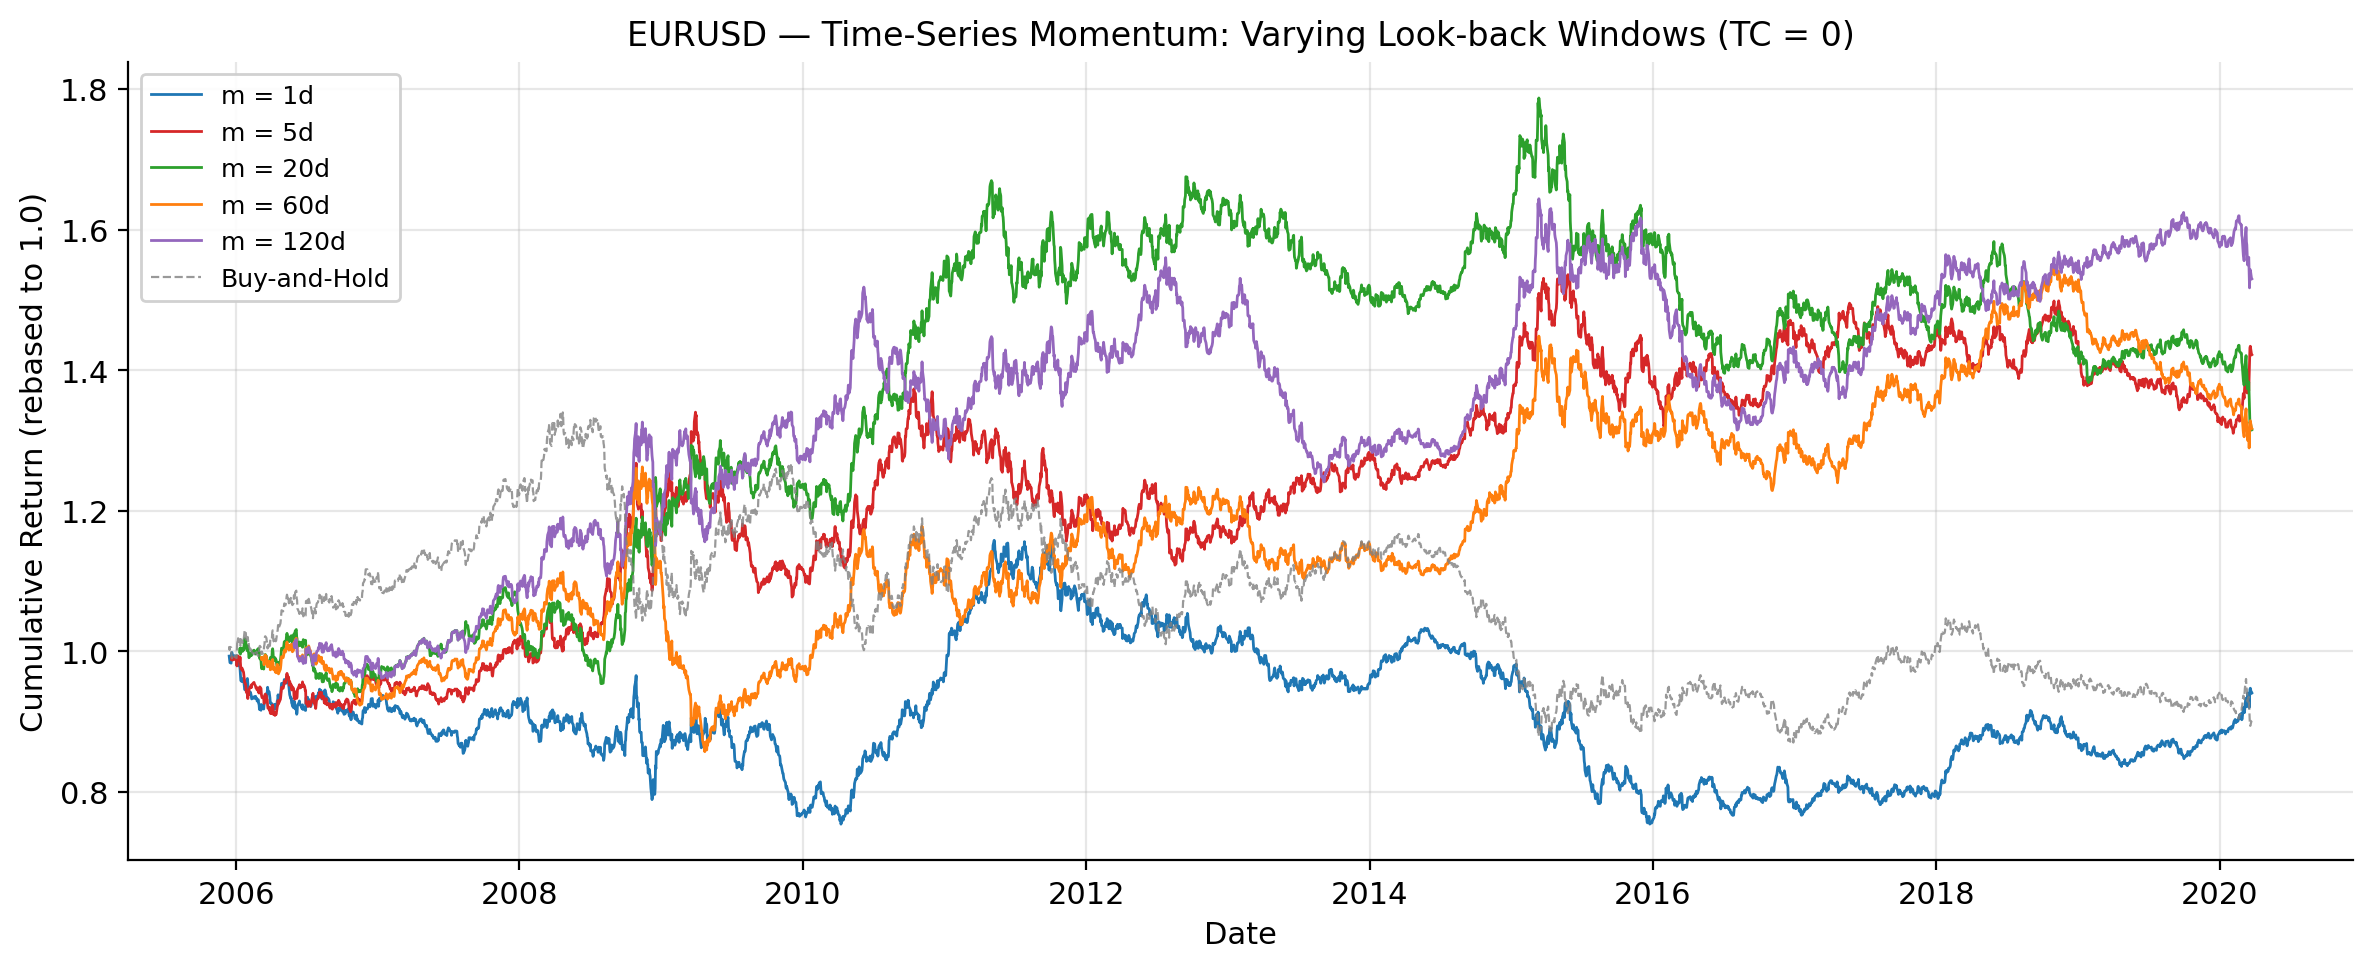

In [16]:
lookbacks = [1, 5, 20, 60, 120]
fig, ax = plt.subplots(figsize=(12, 5))

for lb, col in zip(lookbacks, PALETTE):
    mom_eur.run_strategy(momentum=lb)
    ax.plot(mom_eur.results['cstrategy'], color=col, linewidth=1.0, label=f'm = {lb}d')

mom_eur.run_strategy(momentum=1)
ax.plot(mom_eur.results['creturns'], color='gray', linewidth=0.8, linestyle='--',
        label='Buy-and-Hold', alpha=0.8)

ax.set_title('EURUSD — Time-Series Momentum: Varying Look-back Windows (TC = 0)', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (rebased to 1.0)')
ax.legend(fontsize=9, framealpha=0.9)
plt.tight_layout()
plt.show()

### 3.1.1 Transaction Cost Sensitivity

The annual transaction cost drag is approximately:

$$\text{Annual TC drag} \approx \tau \times \bar{N}_{\text{trades/year}}$$

where $\tau$ is the one-way cost per trade. At $m = 1$, the strategy can reverse position every day. At $m = 20$, position changes are far less frequent and the strategy is substantially more TC-robust. Typical FX spot costs range from 1–2 pips for liquid G10 majors to 5–15 pips for less liquid EM pairs.

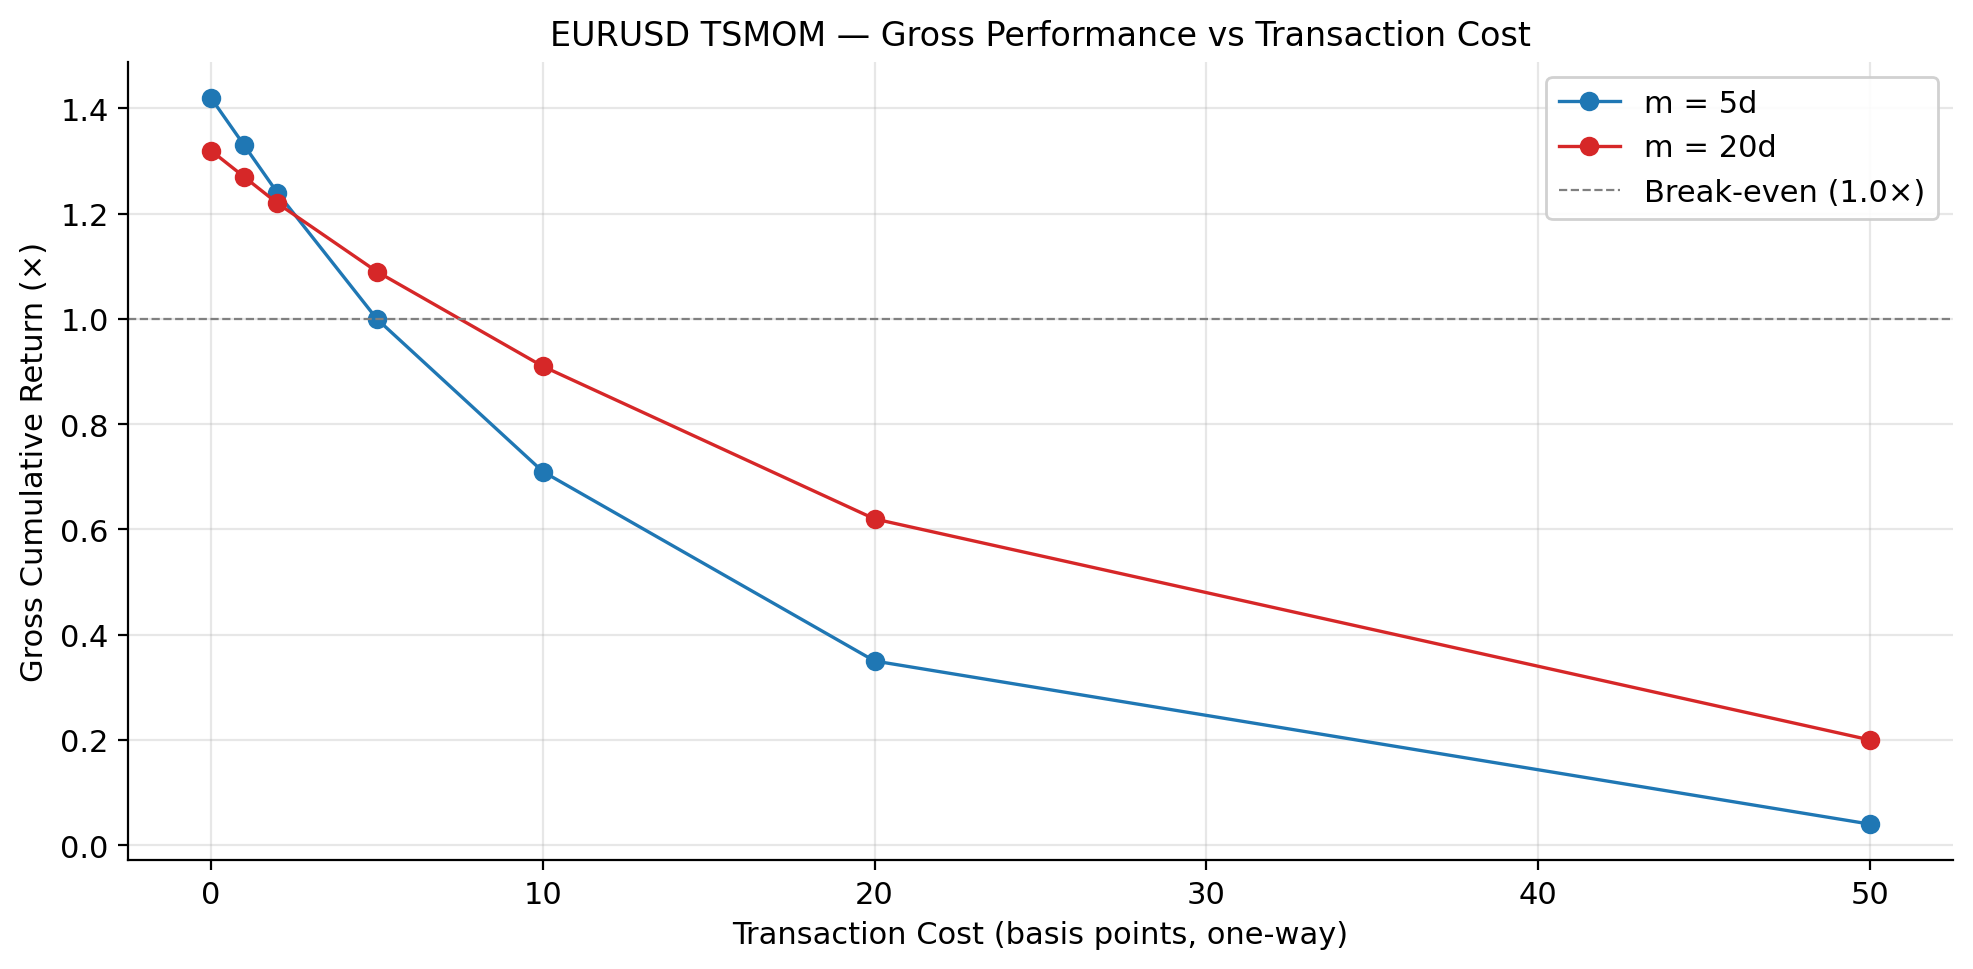

In [17]:
tc_range = [0.0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005]
lb_range  = [5, 20]
tc_results = {lb: [] for lb in lb_range}

for lb in lb_range:
    for tc in tc_range:
        bt = MomVectorBacktester('EURUSD', '12-12-2005', '03-24-2020',
                                 amount=1, tc=tc, data_path=DATA_PATH)
        tc_results[lb].append(bt.run_strategy(momentum=lb)[0])

fig, ax = plt.subplots(figsize=(10, 5))
tc_bps = [t * 10_000 for t in tc_range]
for lb, col in zip(lb_range, [PALETTE[0], PALETTE[1]]):
    ax.plot(tc_bps, tc_results[lb], color=col, marker='o', linewidth=1.2, label=f'm = {lb}d')

ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.8, label='Break-even (1.0×)')
ax.set_title('EURUSD TSMOM — Gross Performance vs Transaction Cost', fontsize=12)
ax.set_xlabel('Transaction Cost (basis points, one-way)')
ax.set_ylabel('Gross Cumulative Return (×)')
ax.legend(framealpha=0.9)
plt.tight_layout()
plt.show()

In [18]:
mom_eur.run_strategy(momentum=20)
tsmom_stats = get_summary_stats(mom_eur.results, label='TSMOM (m=20, TC=0)')

comparison_s2s3 = pd.concat([
    sma_eur_stats,
    tsmom_stats.drop(index='Buy-and-Hold'),
])
comparison_s2s3

Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown
Buy-and-Hold            -0.0146           0.0901       -0.1624       -0.4317
SMA(42/252)              0.0242           0.0901        0.2689       -0.2855
TSMOM (m=20, TC=0)       0.0186           0.0892        0.2089       -0.3068

### 3.1.2 Interpretation

At $m = 1$ the strategy is essentially noise-trading: daily log returns have negligible autocorrelation, so the sign of yesterday's return has little predictive power for today's. As $m$ increases, the rolling mean becomes a more stable estimate of trend direction. A look-back of 20 days aligns with the shortest horizon studied in the academic momentum literature. The TC sensitivity analysis confirms that shorter look-backs, while generating higher gross returns at zero TC, deteriorate sharply as costs rise.

---

### 3.2 EWMA Vol-Normalised Crossover

This strategy addresses two key limitations of SMA and TSMOM: (1) binary positioning irrespective of volatility, and (2) a single look-back horizon. The signal is constructed in four steps.

**Step 1 — Rolling volatility:**
$$\sigma_t = \sqrt{A} \cdot \text{std}\!\left(r_{t-W+1}, \ldots, r_t\right), \qquad A = 252$$

**Step 2 — Vol-normalised synthetic spot:** Divide returns by $\sigma_t$ and cumulate to create a synthetic price series that evolves at constant unit volatility:
$$\tilde{r}_t = \frac{r_t}{\sigma_t}\,\sqrt{A}, \qquad \tilde{S}_t = \sum_{k=1}^{t} \tilde{r}_k$$

**Step 3 — Multi-window EWMA crossover:** For each window pair $(s, \ell)$ in the list $\mathcal{W}$, compute an EWMA crossover on $\tilde{S}_t$ and scale by inverse volatility:
$$\tilde{f}_t^{(s,\ell)} = \frac{\text{sign}\!\left(\text{EWMA}_t^{(s)}(\tilde{S}) - \text{EWMA}_t^{(\ell)}(\tilde{S})\right)}{\sigma_t} \cdot \nu$$

**Step 4 — Average and clip:**
$$p_t = \text{clip}\!\left(\frac{1}{|\mathcal{W}|} \sum_{(s,\ell) \in \mathcal{W}} \tilde{f}_t^{(s,\ell)},\; -1,\; 1\right)$$

The position $p_t$ is **continuous** in $[-1, 1]$, providing implicit volatility targeting: higher volatility reduces position size for the same crossover signal magnitude.

In [19]:
# Adapt Strategy for daily FX data
# annual     : 35040 (intraday default) → 252 (daily)
# vol_window : 480 bars (intraday)      → 60 trading days (≈ 3-month rolling vol)
# longonly   : True (intraday default)  → False (allow long/short)

ewma_strat = Strategy(
    windows_lst=[(16, 64), (32, 128), (64, 256)],
    vol_window=60, vol_scale=0.1, longonly=False, annual=252,
)
signal_eur = ewma_strat.compute_signal(log_returns['EURUSD'])

print(f'Signal range:          [{signal_eur.dropna().min():.4f},  {signal_eur.dropna().max():.4f}]')
print(f'Signal mean:            {signal_eur.dropna().mean():.4f}')
print(f'Non-NaN observations:   {signal_eur.dropna().shape[0]}')
signal_eur.dropna().tail()

Signal range:          [-1.0000,  1.0000]
Signal mean:            -0.0480
Non-NaN observations:   3411


date
2020-03-20   -1.0
2020-03-23   -1.0
2020-03-24   -1.0
2020-03-25   -1.0
2020-03-26   -1.0
dtype: float64

Gross cumulative performance:   1.2775x
Out/underperformance vs BnH:    +0.4401x


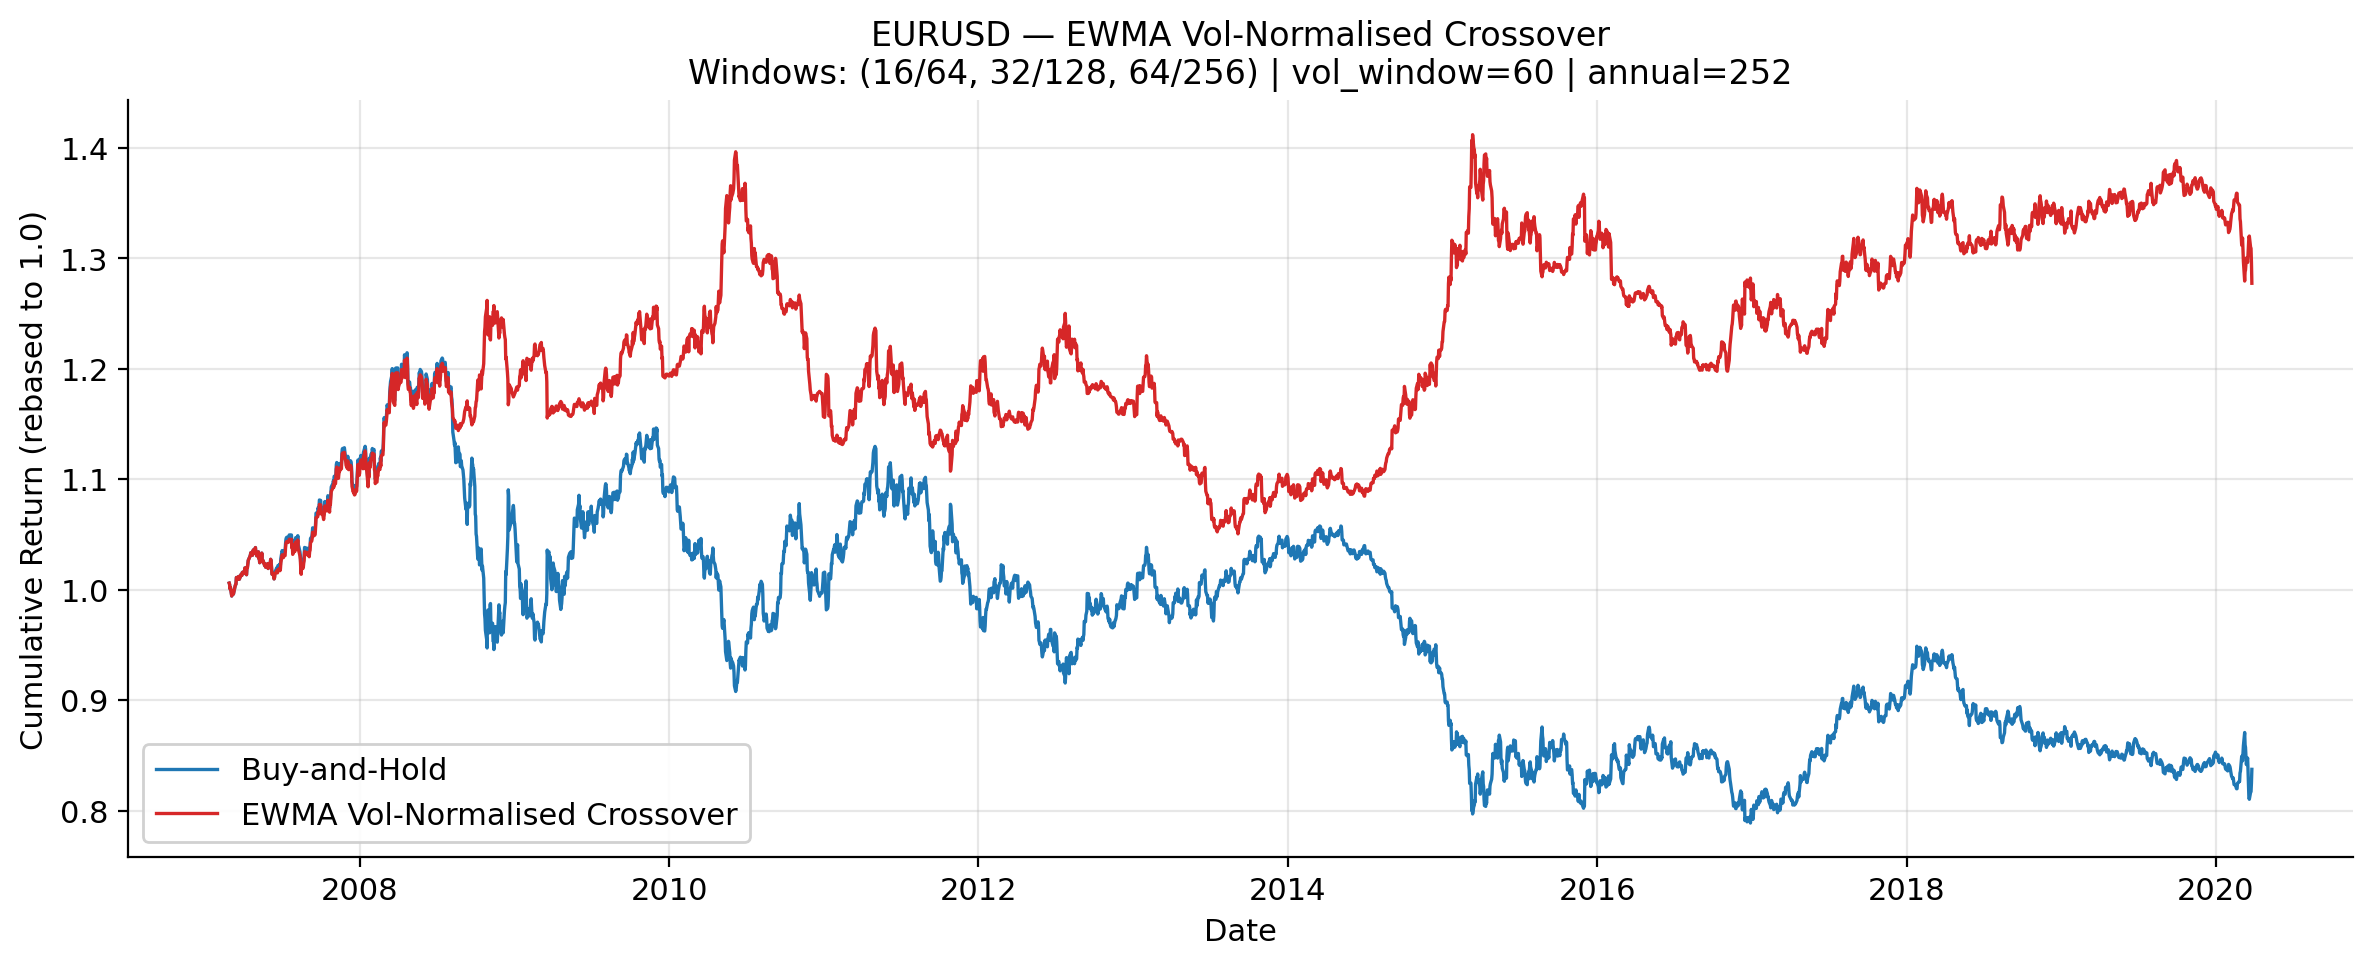

In [20]:
ewma_results = pd.DataFrame({'return': log_returns['EURUSD'], 'signal': signal_eur}).dropna()
ewma_results['strategy'] = ewma_results['signal'].shift(1) * ewma_results['return']
ewma_results.dropna(inplace=True)
ewma_results['creturns']  = ewma_results['return'].cumsum().apply(np.exp)
ewma_results['cstrategy'] = ewma_results['strategy'].cumsum().apply(np.exp)

ewma_ap = ewma_results['cstrategy'].iloc[-1]
ewma_op = ewma_ap - ewma_results['creturns'].iloc[-1]
print(f'Gross cumulative performance:   {ewma_ap:.4f}x')
print(f'Out/underperformance vs BnH:    {ewma_op:+.4f}x')

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ewma_results['creturns'],  color=PALETTE[0], linewidth=1.2, label='Buy-and-Hold')
ax.plot(ewma_results['cstrategy'], color=PALETTE[1], linewidth=1.2, label='EWMA Vol-Normalised Crossover')
ax.set_title('EURUSD — EWMA Vol-Normalised Crossover\nWindows: (16/64, 32/128, 64/256) | vol_window=60 | annual=252', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (rebased to 1.0)')
ax.legend(framealpha=0.9)
plt.tight_layout()
plt.show()

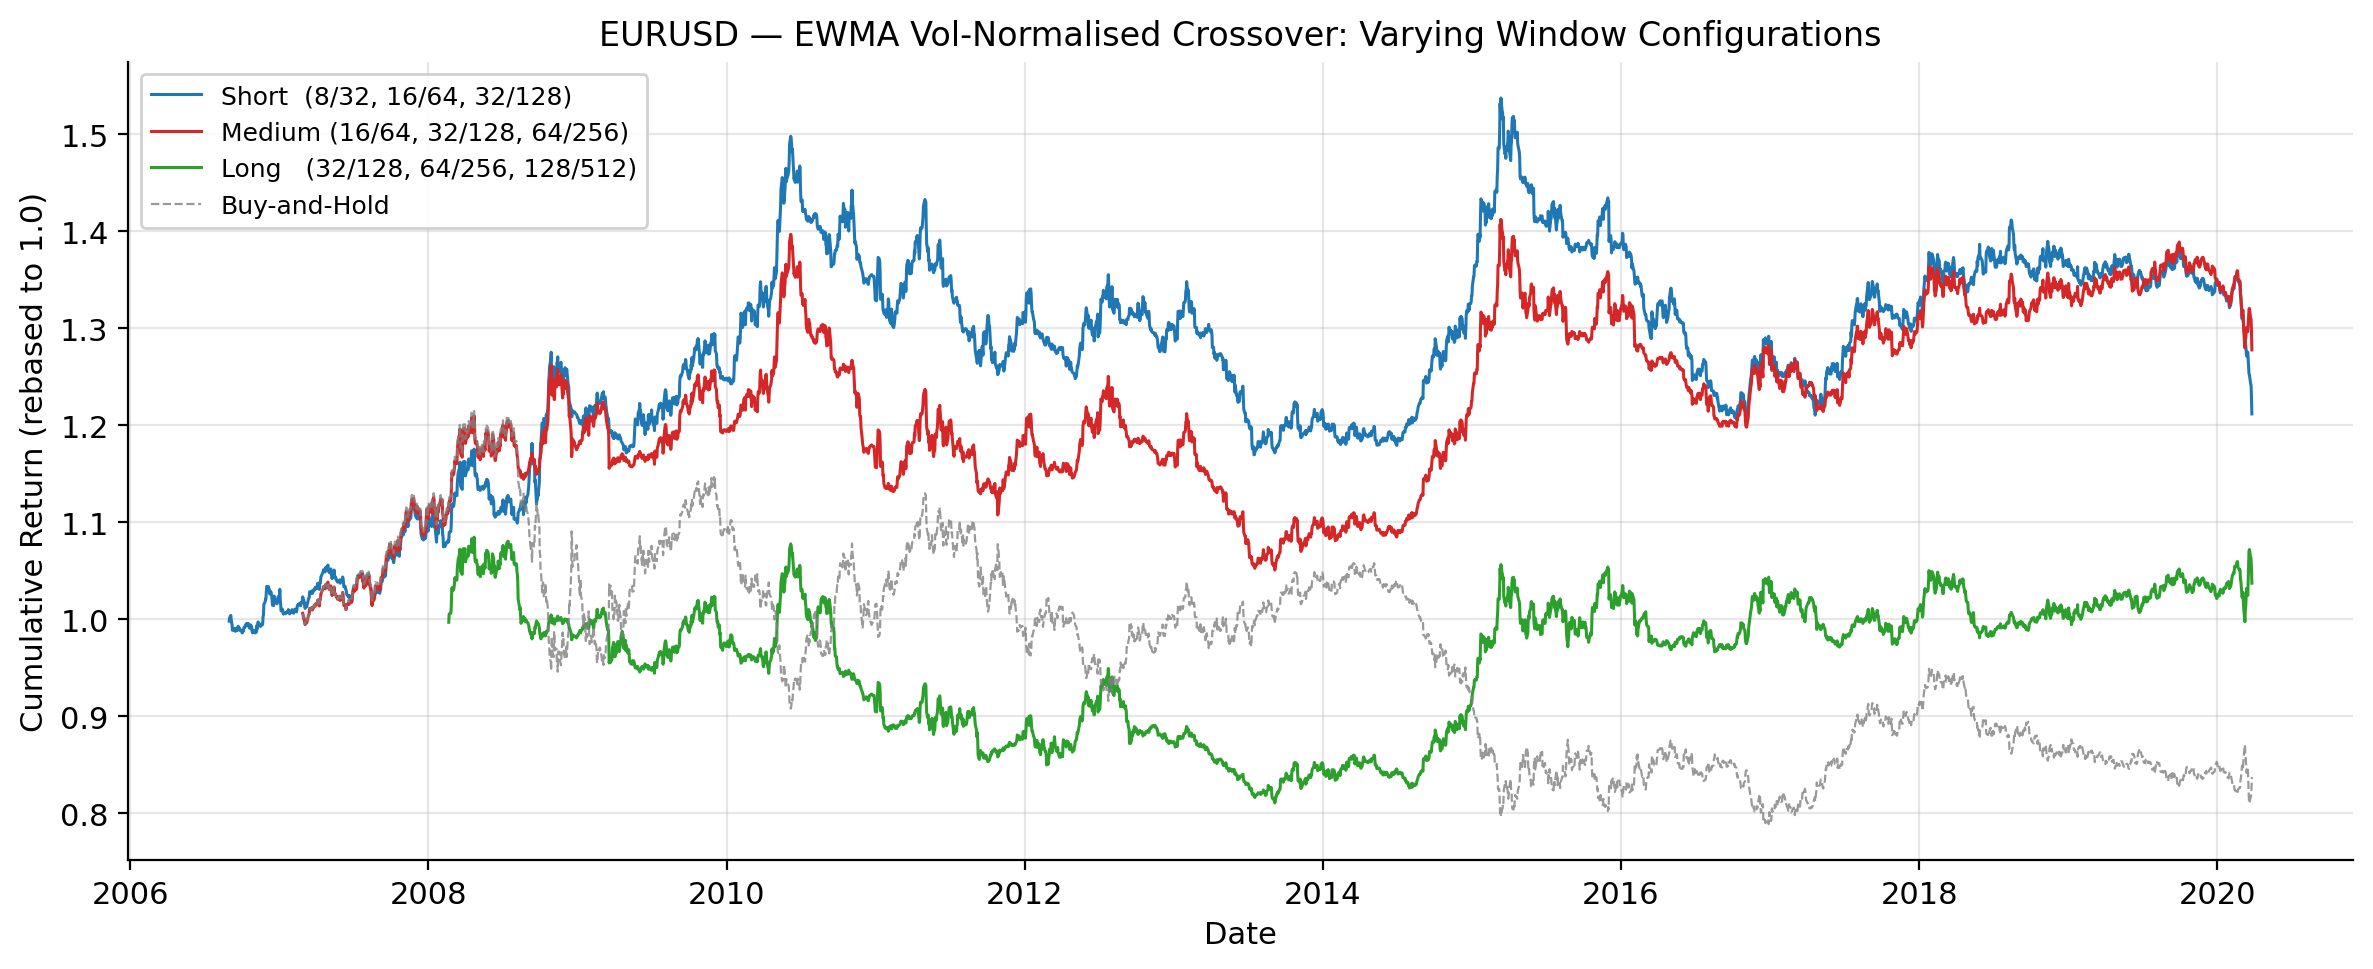

Best window configuration: Medium (16/64, 32/128, 64/256)
Terminal gross return:     1.2775x


In [21]:
windows_configs = {
    'Short  (8/32, 16/64, 32/128)':    [(8, 32),   (16, 64),  (32, 128)],
    'Medium (16/64, 32/128, 64/256)':  [(16, 64),  (32, 128), (64, 256)],
    'Long   (32/128, 64/256, 128/512)': [(32, 128), (64, 256), (128, 512)],
}

ewma_config_results = {}
fig, ax = plt.subplots(figsize=(12, 5))

for (cfg_label, windows), col in zip(windows_configs.items(), PALETTE):
    strat = Strategy(windows_lst=windows, vol_window=60, vol_scale=0.1, longonly=False, annual=252)
    sig = strat.compute_signal(log_returns['EURUSD'])
    df = pd.DataFrame({'return': log_returns['EURUSD'], 'signal': sig}).dropna()
    df['strategy'] = df['signal'].shift(1) * df['return']
    df.dropna(inplace=True)
    df['creturns']  = df['return'].cumsum().apply(np.exp)
    df['cstrategy'] = df['strategy'].cumsum().apply(np.exp)
    ewma_config_results[cfg_label] = df
    ax.plot(df['cstrategy'], color=col, linewidth=1.1, label=cfg_label)

ax.plot(ewma_results['creturns'], color='gray', linewidth=0.8, linestyle='--',
        label='Buy-and-Hold', alpha=0.8)
ax.set_title('EURUSD — EWMA Vol-Normalised Crossover: Varying Window Configurations', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (rebased to 1.0)')
ax.legend(fontsize=9, framealpha=0.9)
plt.tight_layout()
plt.show()

best_cfg = max(ewma_config_results,
               key=lambda k: ewma_config_results[k]['cstrategy'].iloc[-1])
ewma_best_results = ewma_config_results[best_cfg]
print(f'Best window configuration: {best_cfg}')
print(f'Terminal gross return:     {ewma_best_results["cstrategy"].iloc[-1]:.4f}x')

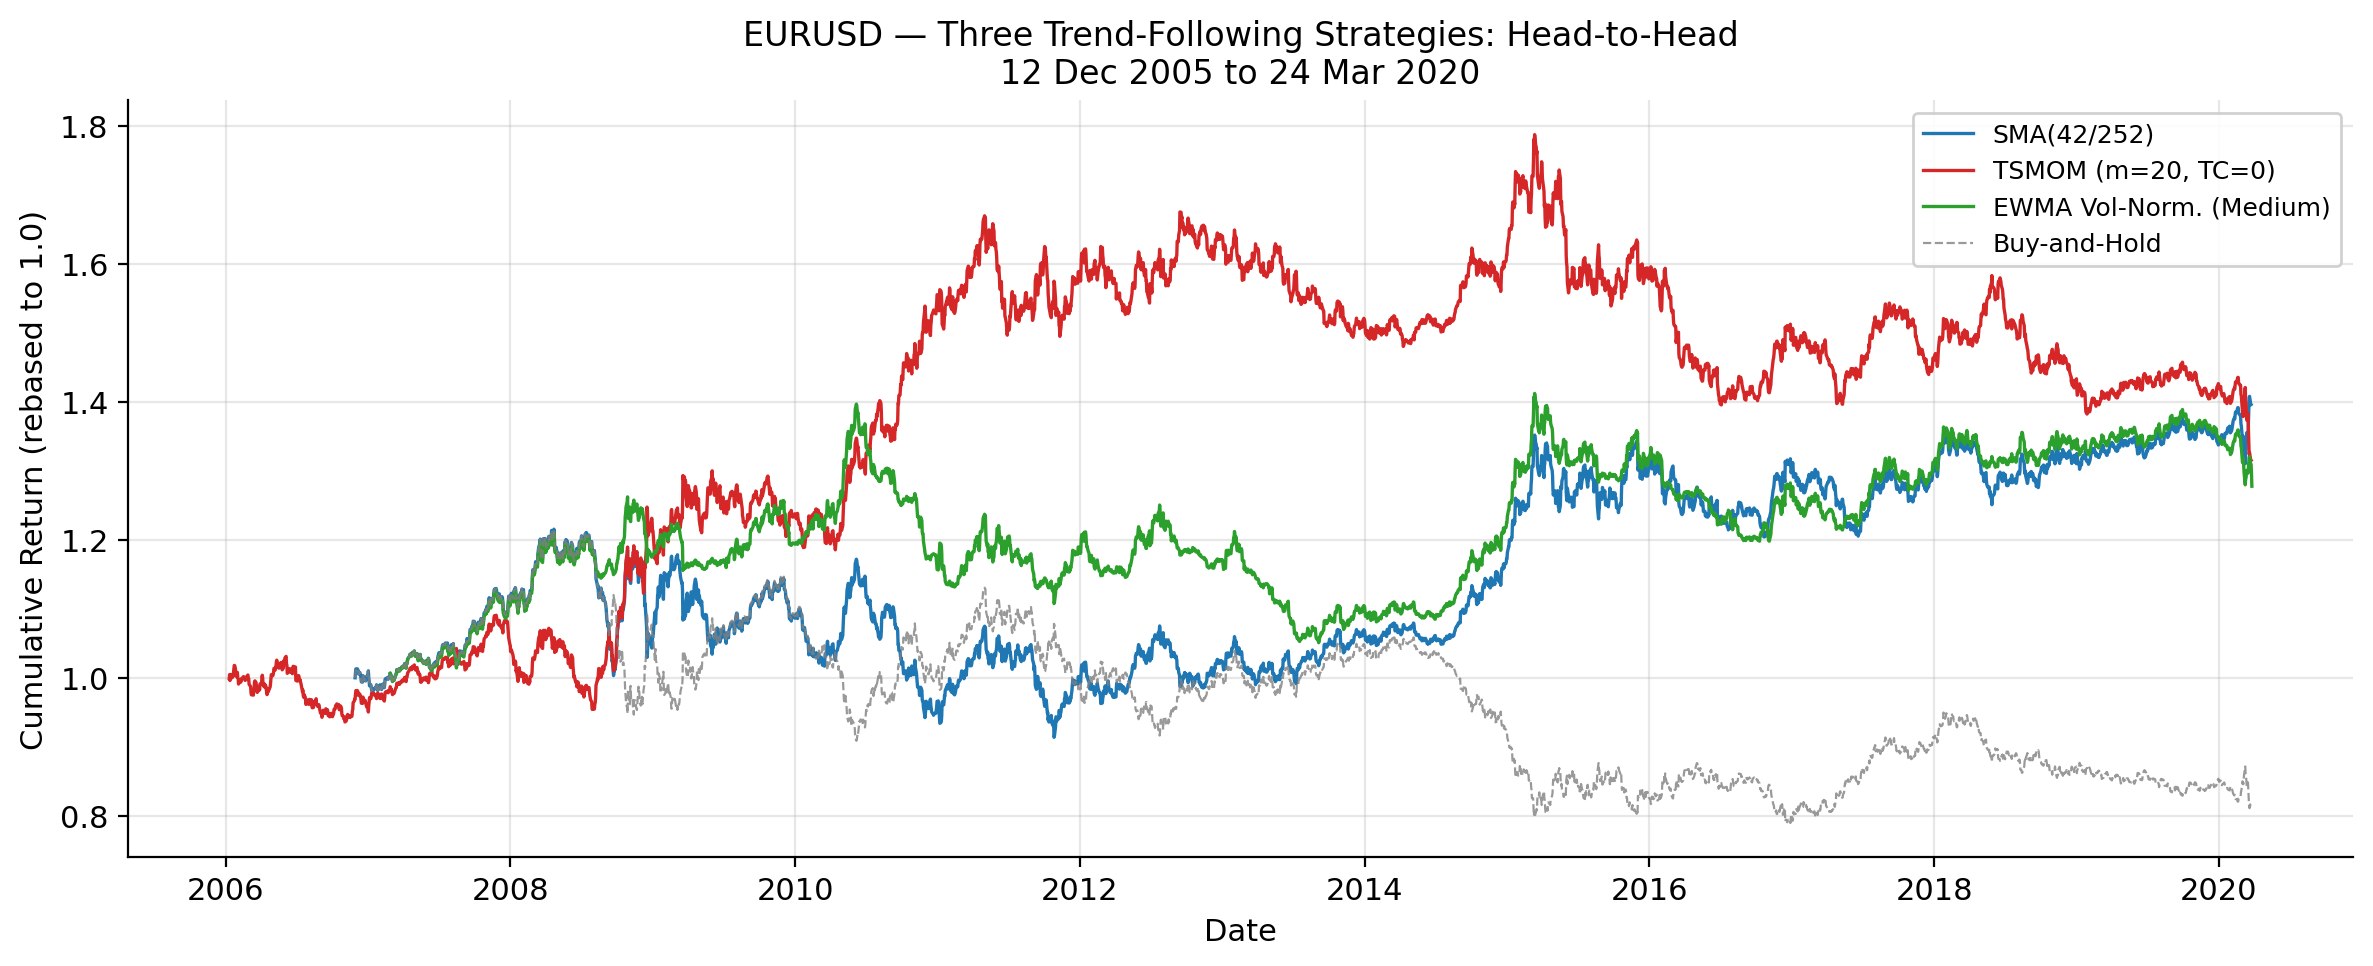

In [22]:
mom_eur.run_strategy(momentum=20)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sma_eur.results['cstrategy'],   color=PALETTE[0], linewidth=1.2,
        label=f'SMA({sma_eur.SMA1}/{sma_eur.SMA2})')
ax.plot(mom_eur.results['cstrategy'],   color=PALETTE[1], linewidth=1.2,
        label='TSMOM (m=20, TC=0)')
ax.plot(ewma_best_results['cstrategy'], color=PALETTE[2], linewidth=1.2,
        label=f'EWMA Vol-Norm. ({best_cfg.split("(")[0].strip()})')
ax.plot(sma_eur.results['creturns'],    color='gray',     linewidth=0.8,
        linestyle='--', label='Buy-and-Hold', alpha=0.8)
ax.set_title('EURUSD — Three Trend-Following Strategies: Head-to-Head\n12 Dec 2005 to 24 Mar 2020', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (rebased to 1.0)')
ax.legend(fontsize=9, framealpha=0.9)
plt.tight_layout()
plt.show()

In [23]:
mom_eur.run_strategy(momentum=20)
tsmom_row = get_summary_stats(mom_eur.results,      label='TSMOM (m=20)').drop(index='Buy-and-Hold')
ewma_row  = get_summary_stats(ewma_best_results,    label=f'EWMA ({best_cfg.split("(")[0].strip()})').drop(index='Buy-and-Hold')
bnh_row   = get_summary_stats(sma_eur.results,      label='SMA').loc[['Buy-and-Hold']]
sma_row   = get_summary_stats(sma_eur.results,      label=f'SMA({sma_eur.SMA1}/{sma_eur.SMA2})').drop(index='Buy-and-Hold')

section3_summary = pd.concat([bnh_row, sma_row, tsmom_row, ewma_row])
section3_summary

Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown
Buy-and-Hold       -0.0146           0.0901       -0.1624       -0.4317
SMA(42/252)         0.0242           0.0901        0.2689       -0.2855
TSMOM (m=20)        0.0186           0.0892        0.2089       -0.3068
EWMA (Medium)       0.0181           0.0710        0.2551       -0.2847

<a id="section-4"></a>
## 4. Multi-Currency Portfolio Analysis

Single-pair backtests are subject to idiosyncratic noise: a strategy may look strong on EURUSD but weak on other pairs due to pair-specific autocorrelation structure, volatility regime, or macro drivers. This section runs all three strategies across eight G10 pairs and assesses whether the trend-following premium is broad-based.

### 4.0 Universe and Portfolio Construction

Eight pairs were selected to cover major liquidity classes and geographic regions, while maintaining clean data throughout the full sample:

| Group | Pairs | Rationale |
|---|---|---|
| G10 Majors | EURUSD, GBPUSD, USDJPY | Highest liquidity; well-documented momentum |
| Commodity currencies | AUDUSD, USDCAD | Risk-on/risk-off regime sensitivity |
| European crosses | USDCHF, USDNOK, USDSEK | Diversified European exposure; NOK and SEK are commodity-linked |

Note the sign convention: pairs quoted as USD/XXX (e.g. USDJPY) are **dollar-base** pairs — a positive log return means the dollar strengthened. The strategy positions are interpreted consistently: a long position (+1) is always long the first currency in the pair name.

The equal-weight portfolio daily return is:

$$r_t^{\text{port}} = \frac{1}{N} \sum_{i=1}^{N} \pi_t^{(i)}, \qquad N = 8$$

where $\pi_t^{(i)}$ is the strategy log return of pair $i$ on day $t$. The sum is taken on the common inner-join index, ensuring $r_t^{\text{port}}$ is only computed on days when all $N$ pairs have valid data.

In [24]:
PAIRS = ['EURUSD', 'GBPUSD', 'AUDUSD', 'USDCAD', 'USDJPY', 'USDCHF', 'USDNOK', 'USDSEK']

# Shared parameters
SMA_N1, SMA_N2   = 42, 252
MOM_M,  MOM_TC   = 20, 0.0001          # 1 bp one-way TC for TSMOM
EWMA_WINDOWS     = [(16, 64), (32, 128), (64, 256)]

sma_strategies  = {}
mom_strategies  = {}
ewma_strategies = {}

print(f'{"Pair":>8}  {"SMA(42/252)":>12}  {"TSMOM(m=20)":>12}  {"EWMA Vol-N.":>12}')
print('-' * 52)

for sym in PAIRS:
    sma_bt = SMAVectorBacktester(sym, SMA_N1, SMA_N2, '12-12-2005', '03-24-2020', data_path=DATA_PATH)
    sma_ap, _ = sma_bt.run_strategy()
    sma_strategies[sym] = sma_bt

    mom_bt = MomVectorBacktester(sym, '12-12-2005', '03-24-2020', amount=1, tc=MOM_TC, data_path=DATA_PATH)
    mom_ap, _ = mom_bt.run_strategy(momentum=MOM_M)
    mom_strategies[sym] = mom_bt

    ewma_bt = EWMACrossoverBacktester(sym, '12-12-2005', '03-24-2020',
                                      data_path=DATA_PATH, windows_lst=EWMA_WINDOWS)
    ewma_ap, _ = ewma_bt.run_strategy()
    ewma_strategies[sym] = ewma_bt

    print(f'{sym:>8}  {sma_ap:>12.4f}  {mom_ap:>12.4f}  {ewma_ap:>12.4f}')

    Pair   SMA(42/252)   TSMOM(m=20)   EWMA Vol-N.
----------------------------------------------------
  EURUSD        1.4000        1.2700        1.3100
  GBPUSD        1.0100        0.8700        1.2200
  AUDUSD        0.9400        1.8200        1.4500
  USDCAD        1.2500        0.7100        1.1300
  USDJPY        1.0100        1.3800        1.2300
  USDCHF        1.0400        0.8500        0.9800
  USDNOK        2.0000        0.8700        1.4200
  USDSEK        1.4900        0.5700        1.1900


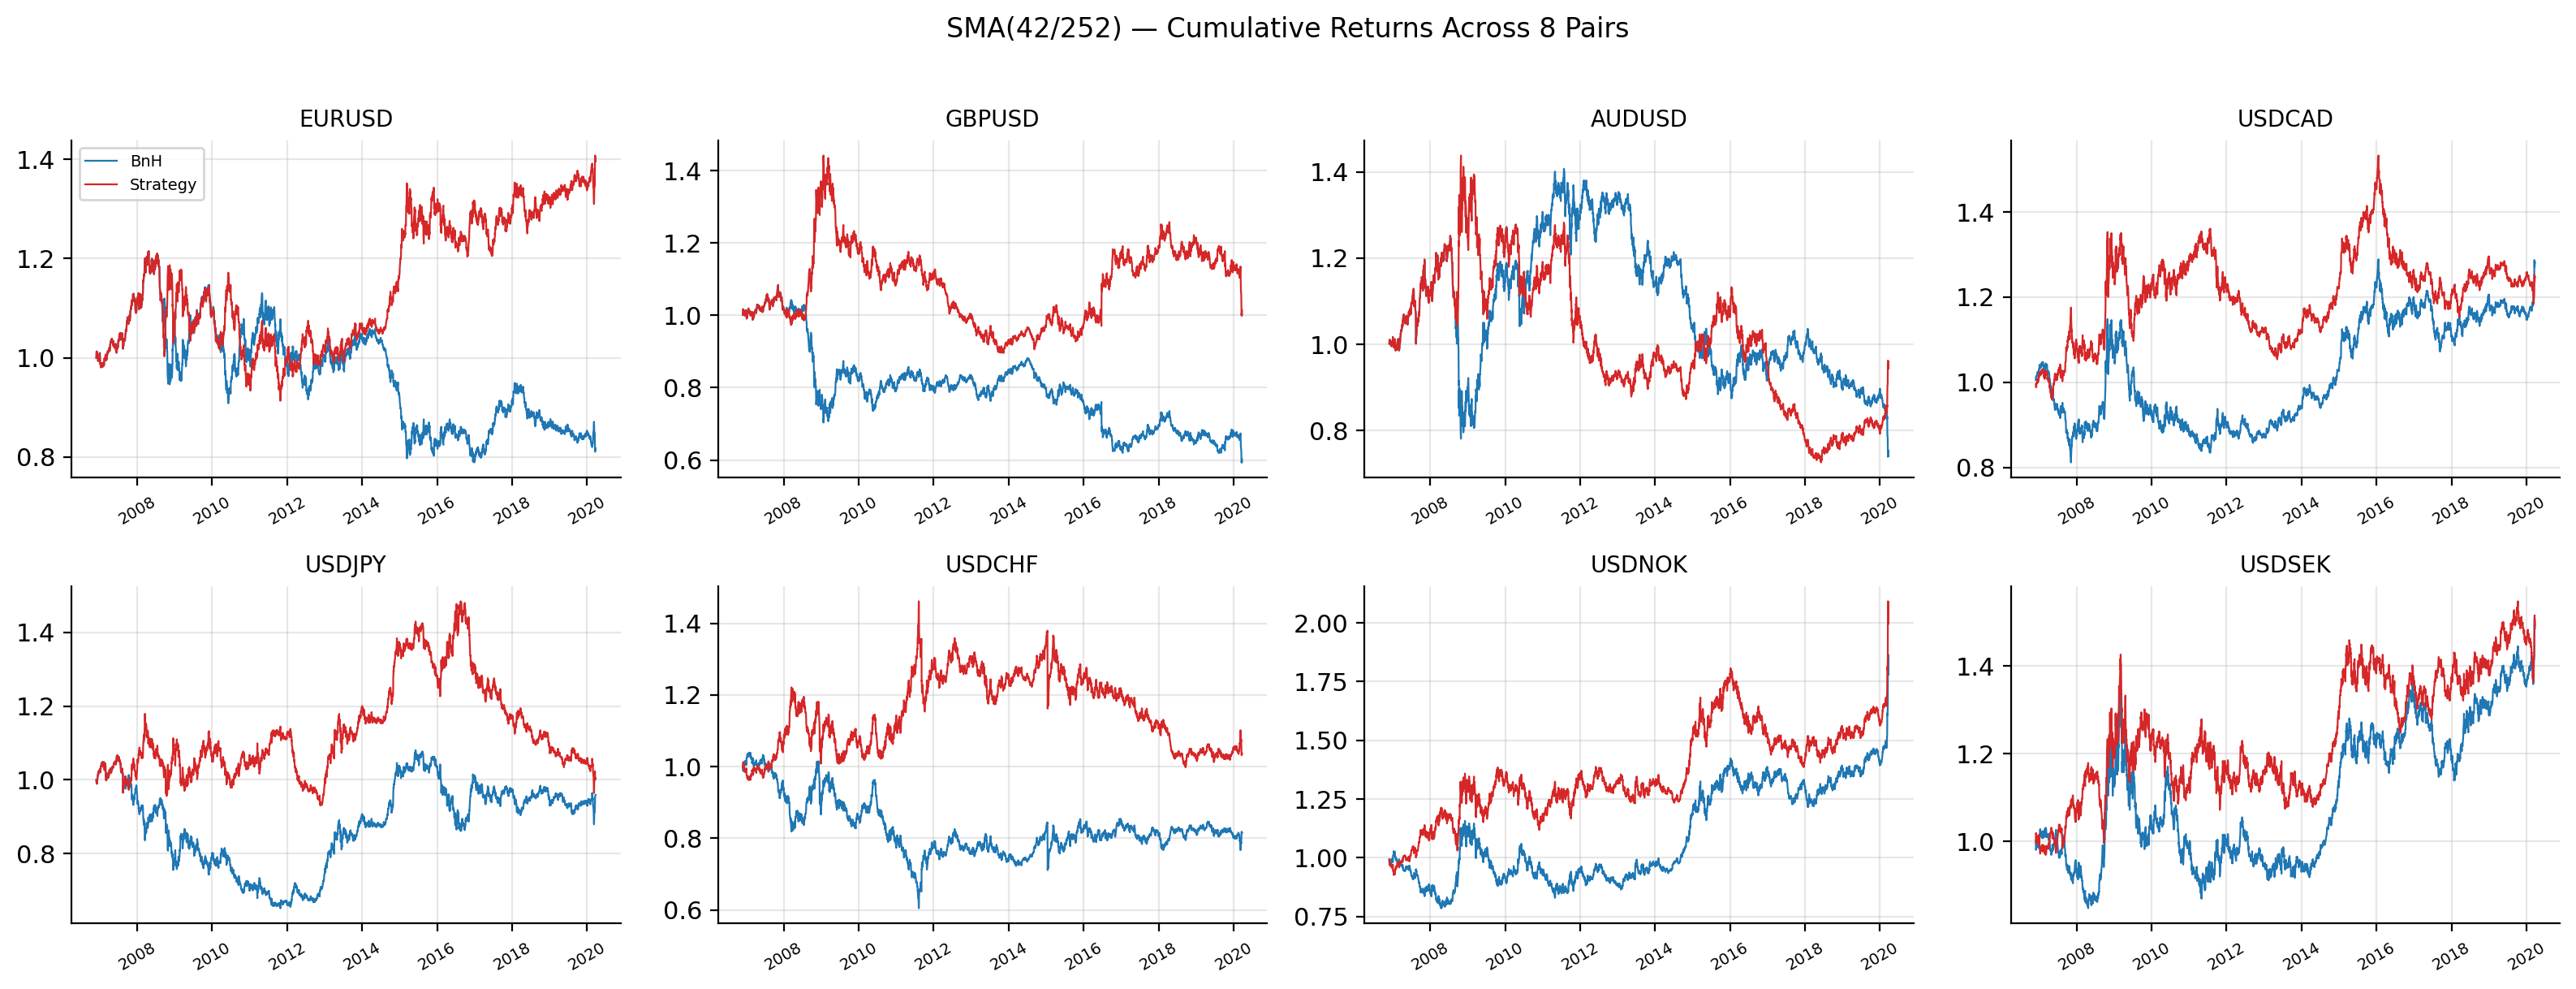

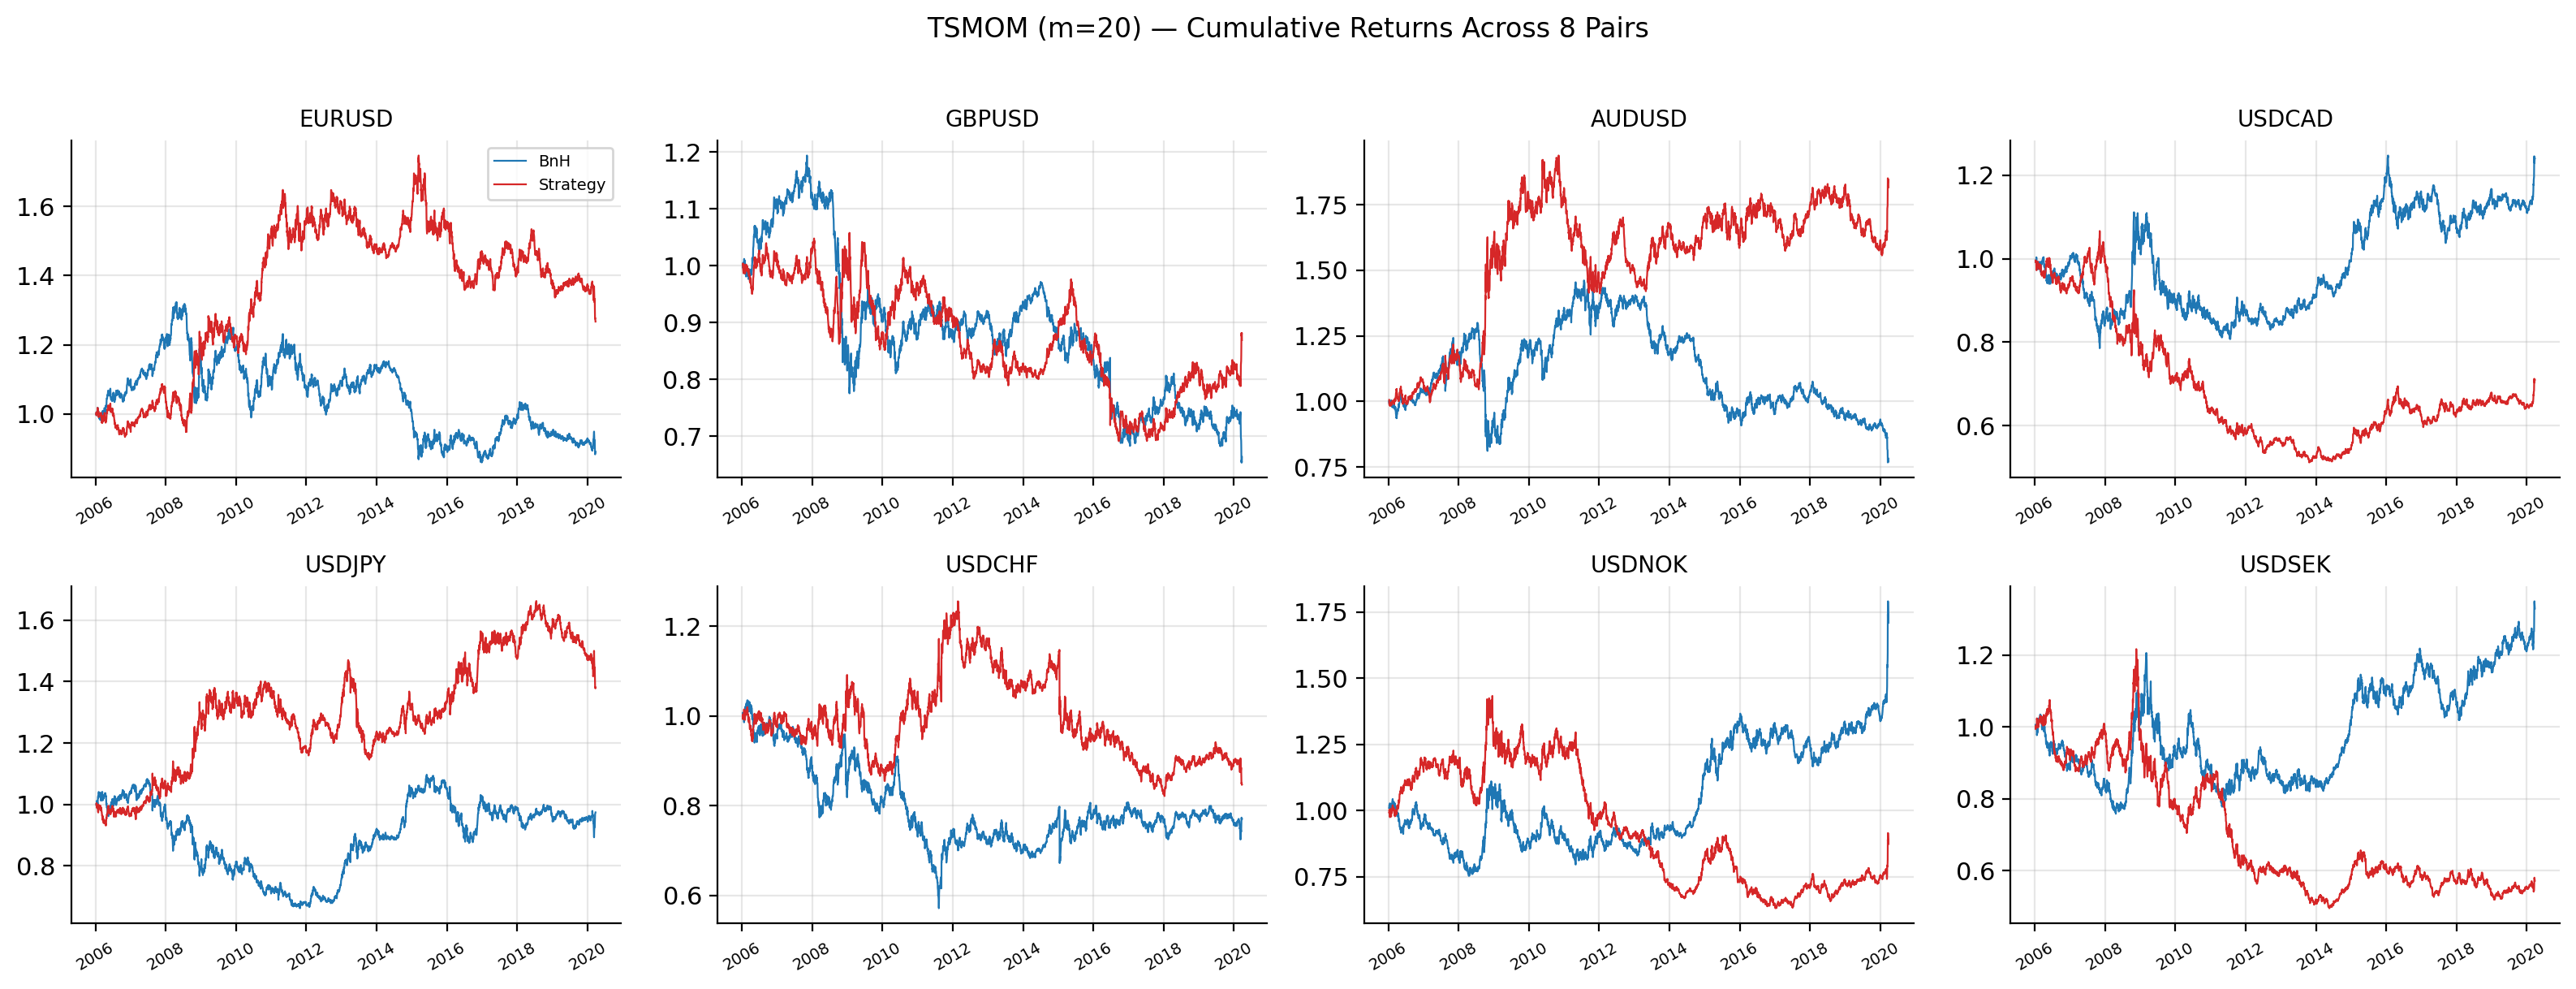

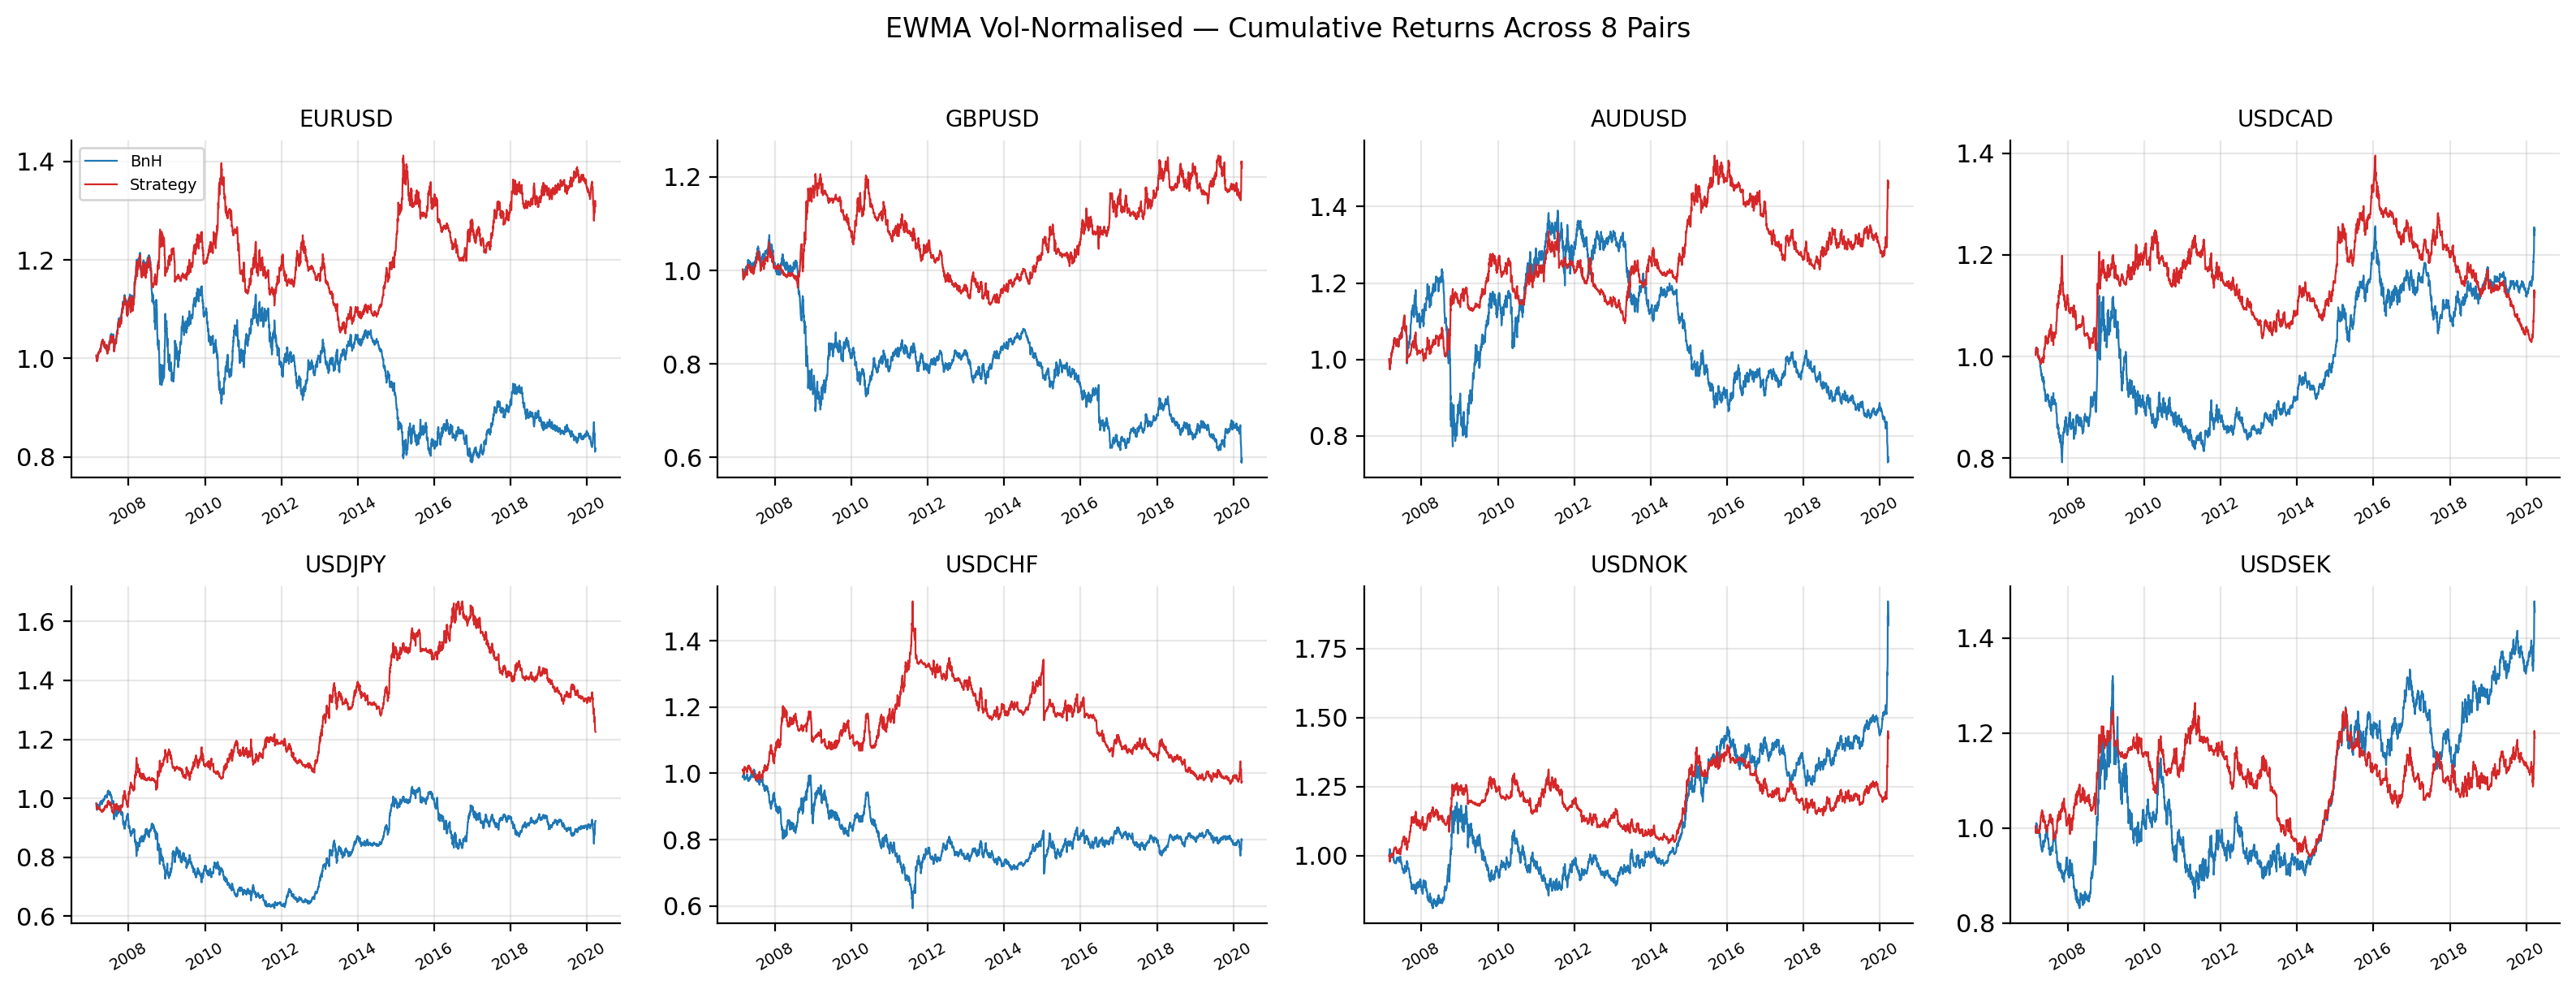

In [25]:
# Individual pair cumulative return charts — one 2×4 grid per strategy
for strategy_name, strategies, col_strat in [
    (f'SMA({SMA_N1}/{SMA_N2})',      sma_strategies,  PALETTE[1]),
    (f'TSMOM (m={MOM_M})',           mom_strategies,  PALETTE[1]),
    ('EWMA Vol-Normalised',          ewma_strategies, PALETTE[1]),
]:
    fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharey=False)
    axes = axes.flatten()

    for i, sym in enumerate(PAIRS):
        bt  = strategies[sym]
        res = bt.results
        axes[i].plot(res['creturns'],  color=PALETTE[0], linewidth=0.8, label='BnH')
        axes[i].plot(res['cstrategy'], color=col_strat,  linewidth=0.8, label='Strategy')
        axes[i].set_title(sym, fontsize=10)
        axes[i].tick_params(axis='x', rotation=30, labelsize=7)
        if i == 0:
            axes[i].legend(fontsize=7, framealpha=0.8)

    fig.suptitle(f'{strategy_name} — Cumulative Returns Across 8 Pairs', fontsize=12, y=1.01)
    plt.tight_layout()
    plt.show()

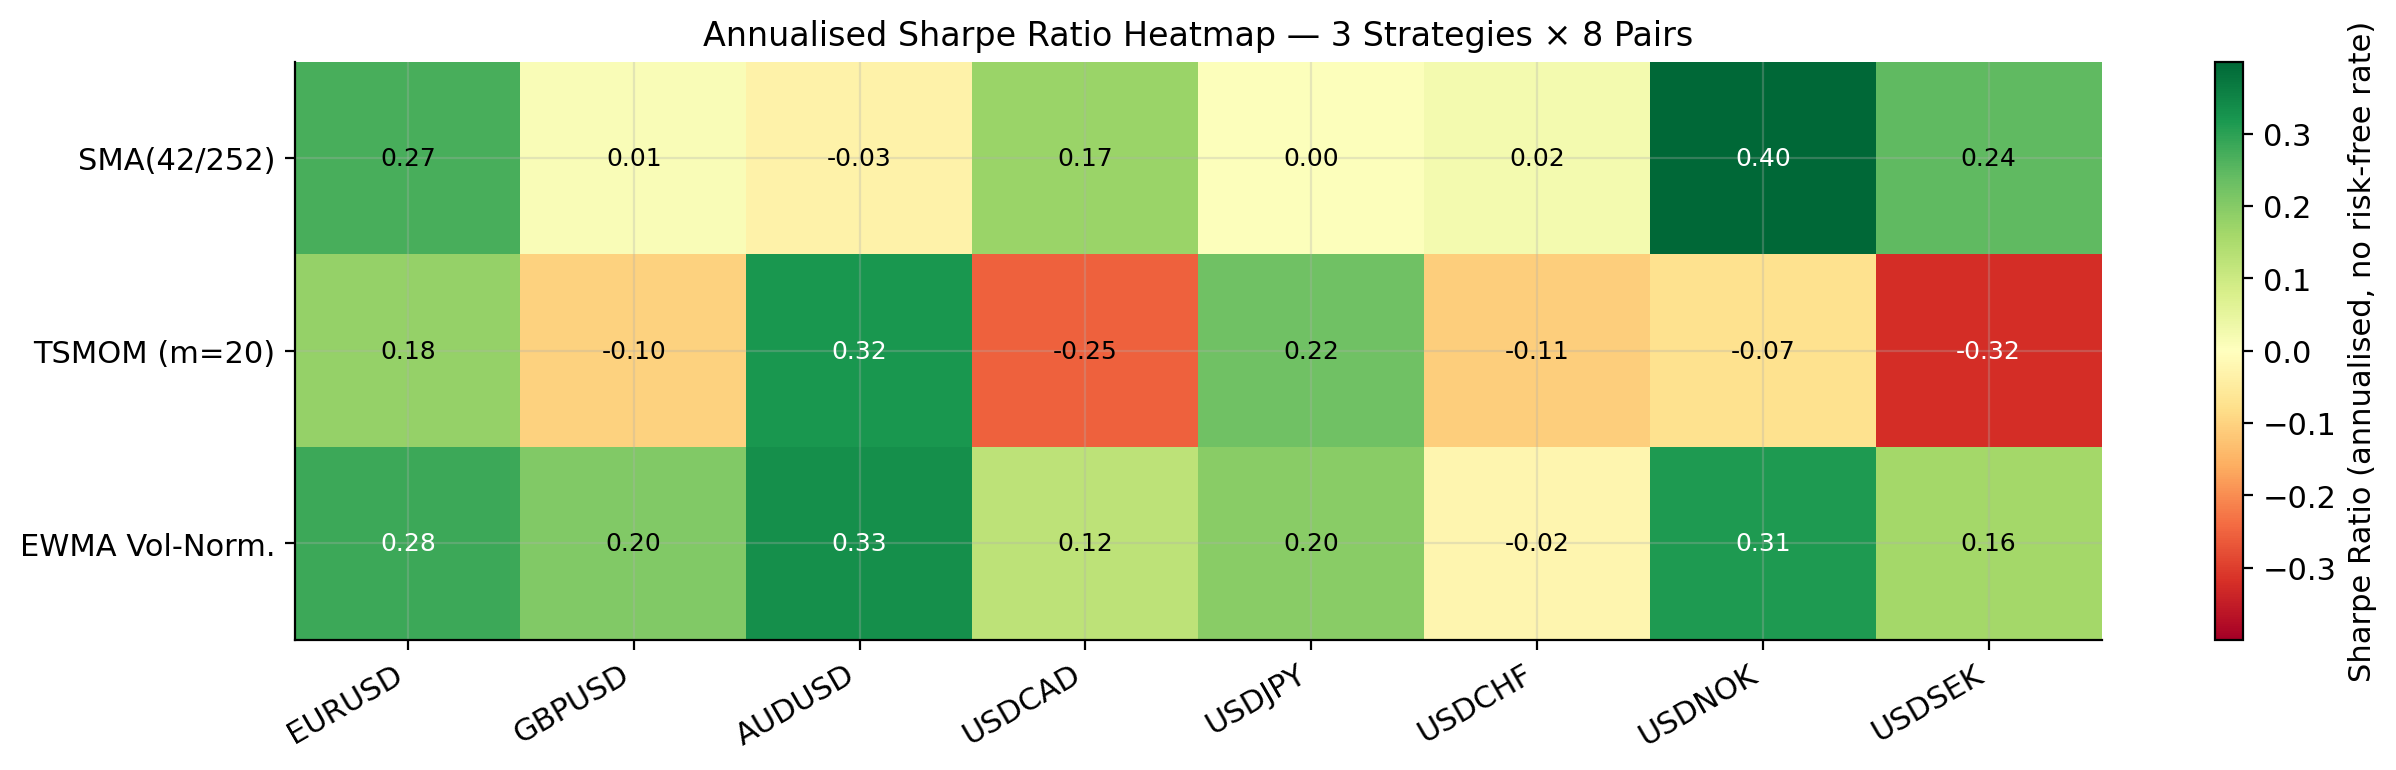

In [26]:
# Annualised Sharpe ratio for each pair × strategy combination
def ann_sharpe(r, days=252):
    r = r.dropna()
    v = r.std() * np.sqrt(days)
    return (r.mean() * days) / v if v > 0 else np.nan

strategy_labels = [f'SMA({SMA_N1}/{SMA_N2})', f'TSMOM (m={MOM_M})', 'EWMA Vol-Norm.']
sharpe_matrix = np.zeros((3, len(PAIRS)))

for j, sym in enumerate(PAIRS):
    sharpe_matrix[0, j] = ann_sharpe(sma_strategies[sym].results['strategy'])
    sharpe_matrix[1, j] = ann_sharpe(mom_strategies[sym].results['strategy'])
    sharpe_matrix[2, j] = ann_sharpe(ewma_strategies[sym].results['strategy'])

fig, ax = plt.subplots(figsize=(13, 4))
vabs = max(abs(sharpe_matrix.min()), abs(sharpe_matrix.max()))
im = ax.imshow(sharpe_matrix, cmap='RdYlGn', vmin=-vabs, vmax=vabs, aspect='auto')

ax.set_xticks(range(len(PAIRS)))
ax.set_xticklabels(PAIRS, rotation=30, ha='right')
ax.set_yticks(range(3))
ax.set_yticklabels(strategy_labels)
ax.set_title('Annualised Sharpe Ratio Heatmap — 3 Strategies × 8 Pairs', fontsize=12)
plt.colorbar(im, ax=ax, label='Sharpe Ratio (annualised, no risk-free rate)')

for i in range(3):
    for j in range(len(PAIRS)):
        ax.text(j, i, f'{sharpe_matrix[i, j]:.2f}',
                ha='center', va='center', fontsize=9,
                color='black' if abs(sharpe_matrix[i, j]) < vabs * 0.7 else 'white')

plt.tight_layout()
plt.show()

In [27]:
# Equal-weight portfolio: align on common inner-join index, then average
sma_ret_all  = pd.DataFrame({s: sma_strategies[s].results['strategy']  for s in PAIRS}).dropna()
mom_ret_all  = pd.DataFrame({s: mom_strategies[s].results['strategy']  for s in PAIRS}).dropna()
ewma_ret_all = pd.DataFrame({s: ewma_strategies[s].results['strategy'] for s in PAIRS}).dropna()

sma_port  = sma_ret_all.mean(axis=1)
mom_port  = mom_ret_all.mean(axis=1)
ewma_port = ewma_ret_all.mean(axis=1)

print(f'SMA  portfolio — {len(sma_ret_all)} common trading days '
      f'({sma_ret_all.index[0].date()} to {sma_ret_all.index[-1].date()})')
print(f'TSMOM portfolio — {len(mom_ret_all)} common trading days '
      f'({mom_ret_all.index[0].date()} to {mom_ret_all.index[-1].date()})')
print(f'EWMA  portfolio — {len(ewma_ret_all)} common trading days '
      f'({ewma_ret_all.index[0].date()} to {ewma_ret_all.index[-1].date()})')

SMA  portfolio — 3472 common trading days (2006-11-29 to 2020-03-24)
TSMOM portfolio — 3703 common trading days (2006-01-10 to 2020-03-24)
EWMA  portfolio — 3408 common trading days (2007-02-27 to 2020-03-24)


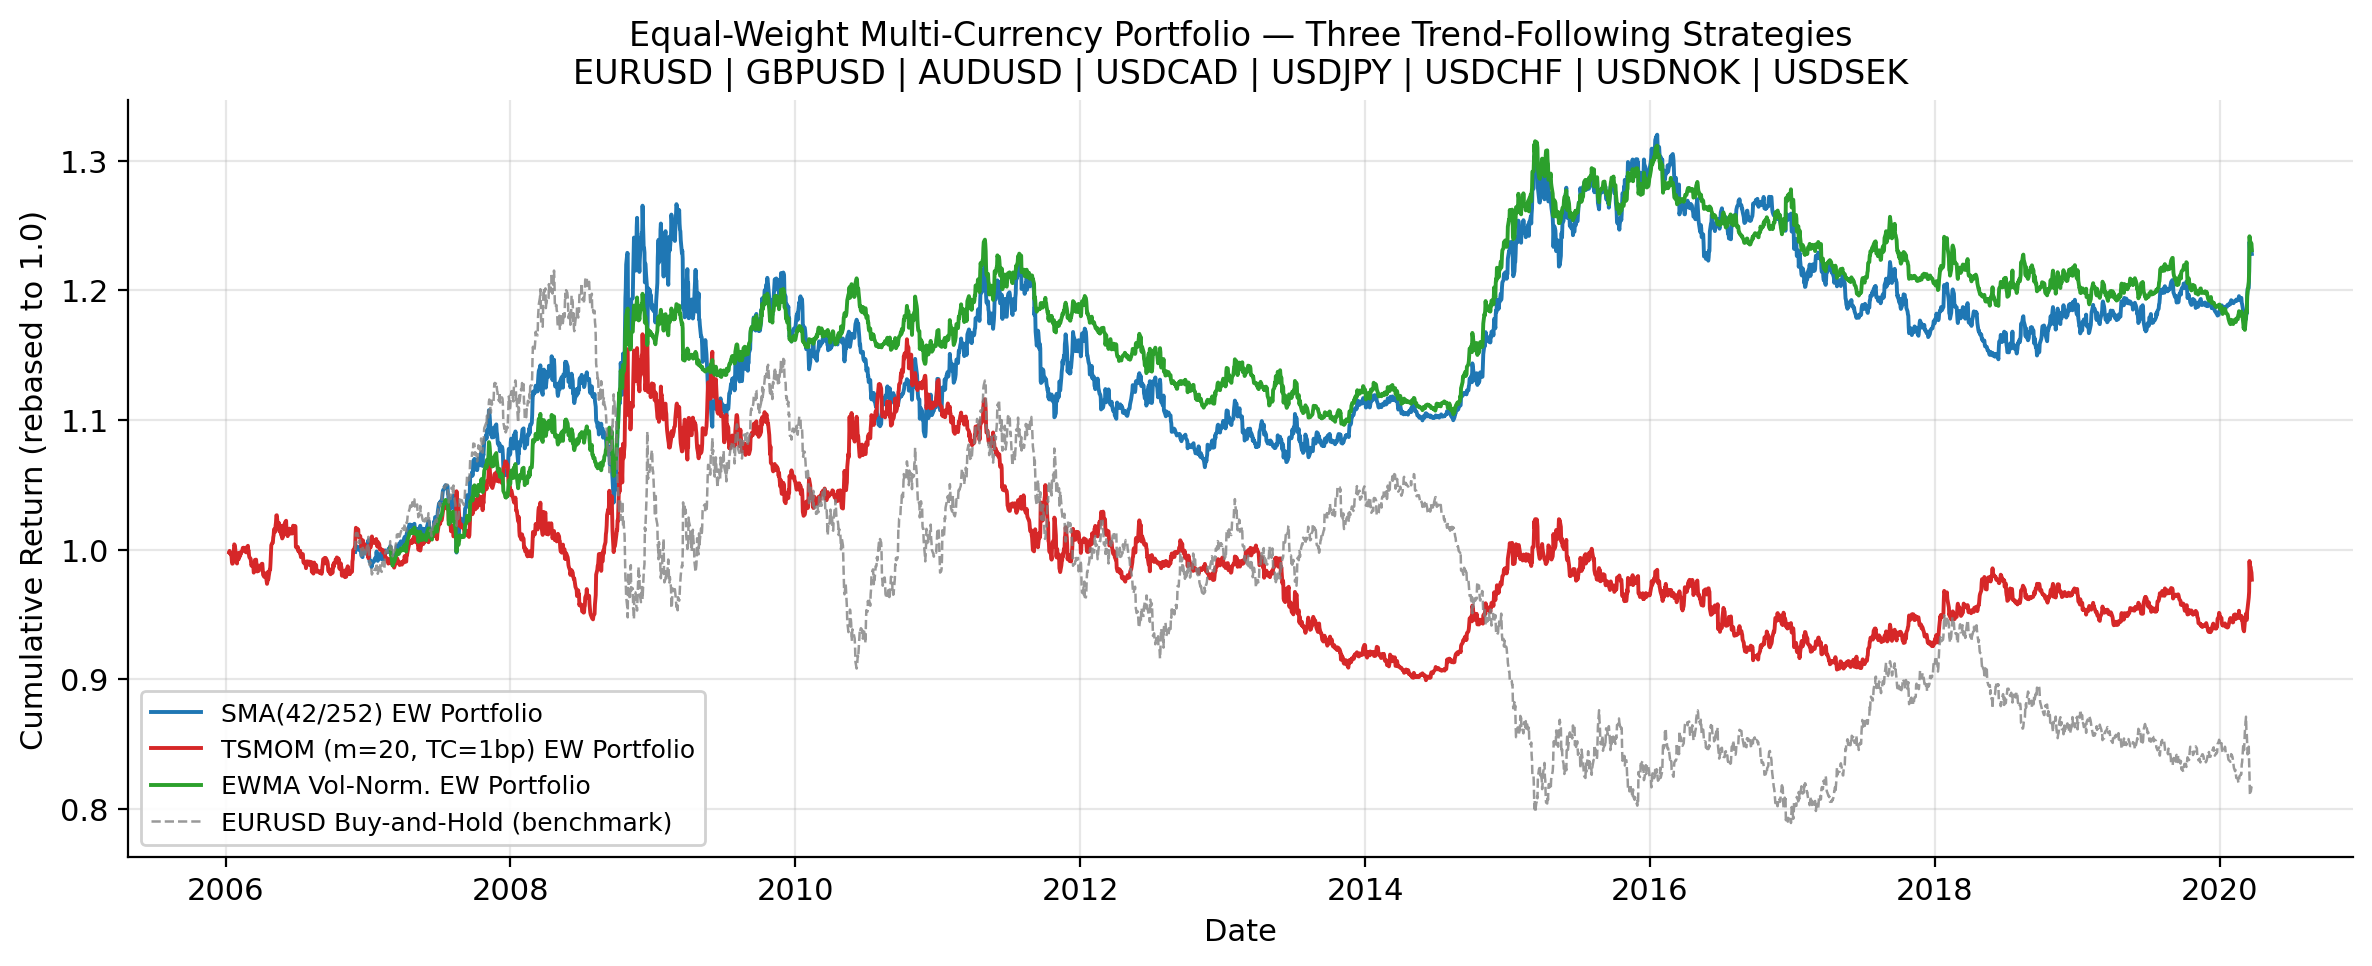

In [28]:
# Cumulative portfolio returns and EURUSD buy-and-hold benchmark
sma_port_cum  = sma_port.cumsum().apply(np.exp)
mom_port_cum  = mom_port.cumsum().apply(np.exp)
ewma_port_cum = ewma_port.cumsum().apply(np.exp)
bnh_cum       = sma_strategies['EURUSD'].results['creturns']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sma_port_cum,  color=PALETTE[0], linewidth=1.4, label=f'SMA({SMA_N1}/{SMA_N2}) EW Portfolio')
ax.plot(mom_port_cum,  color=PALETTE[1], linewidth=1.4, label=f'TSMOM (m={MOM_M}, TC=1bp) EW Portfolio')
ax.plot(ewma_port_cum, color=PALETTE[2], linewidth=1.4, label='EWMA Vol-Norm. EW Portfolio')
ax.plot(bnh_cum,       color='gray',     linewidth=0.9, linestyle='--',
        label='EURUSD Buy-and-Hold (benchmark)', alpha=0.8)
ax.set_title(
    'Equal-Weight Multi-Currency Portfolio — Three Trend-Following Strategies\n'
    'EURUSD | GBPUSD | AUDUSD | USDCAD | USDJPY | USDCHF | USDNOK | USDSEK',
    fontsize=12,
)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (rebased to 1.0)')
ax.legend(fontsize=9, framealpha=0.9)
plt.tight_layout()
plt.show()

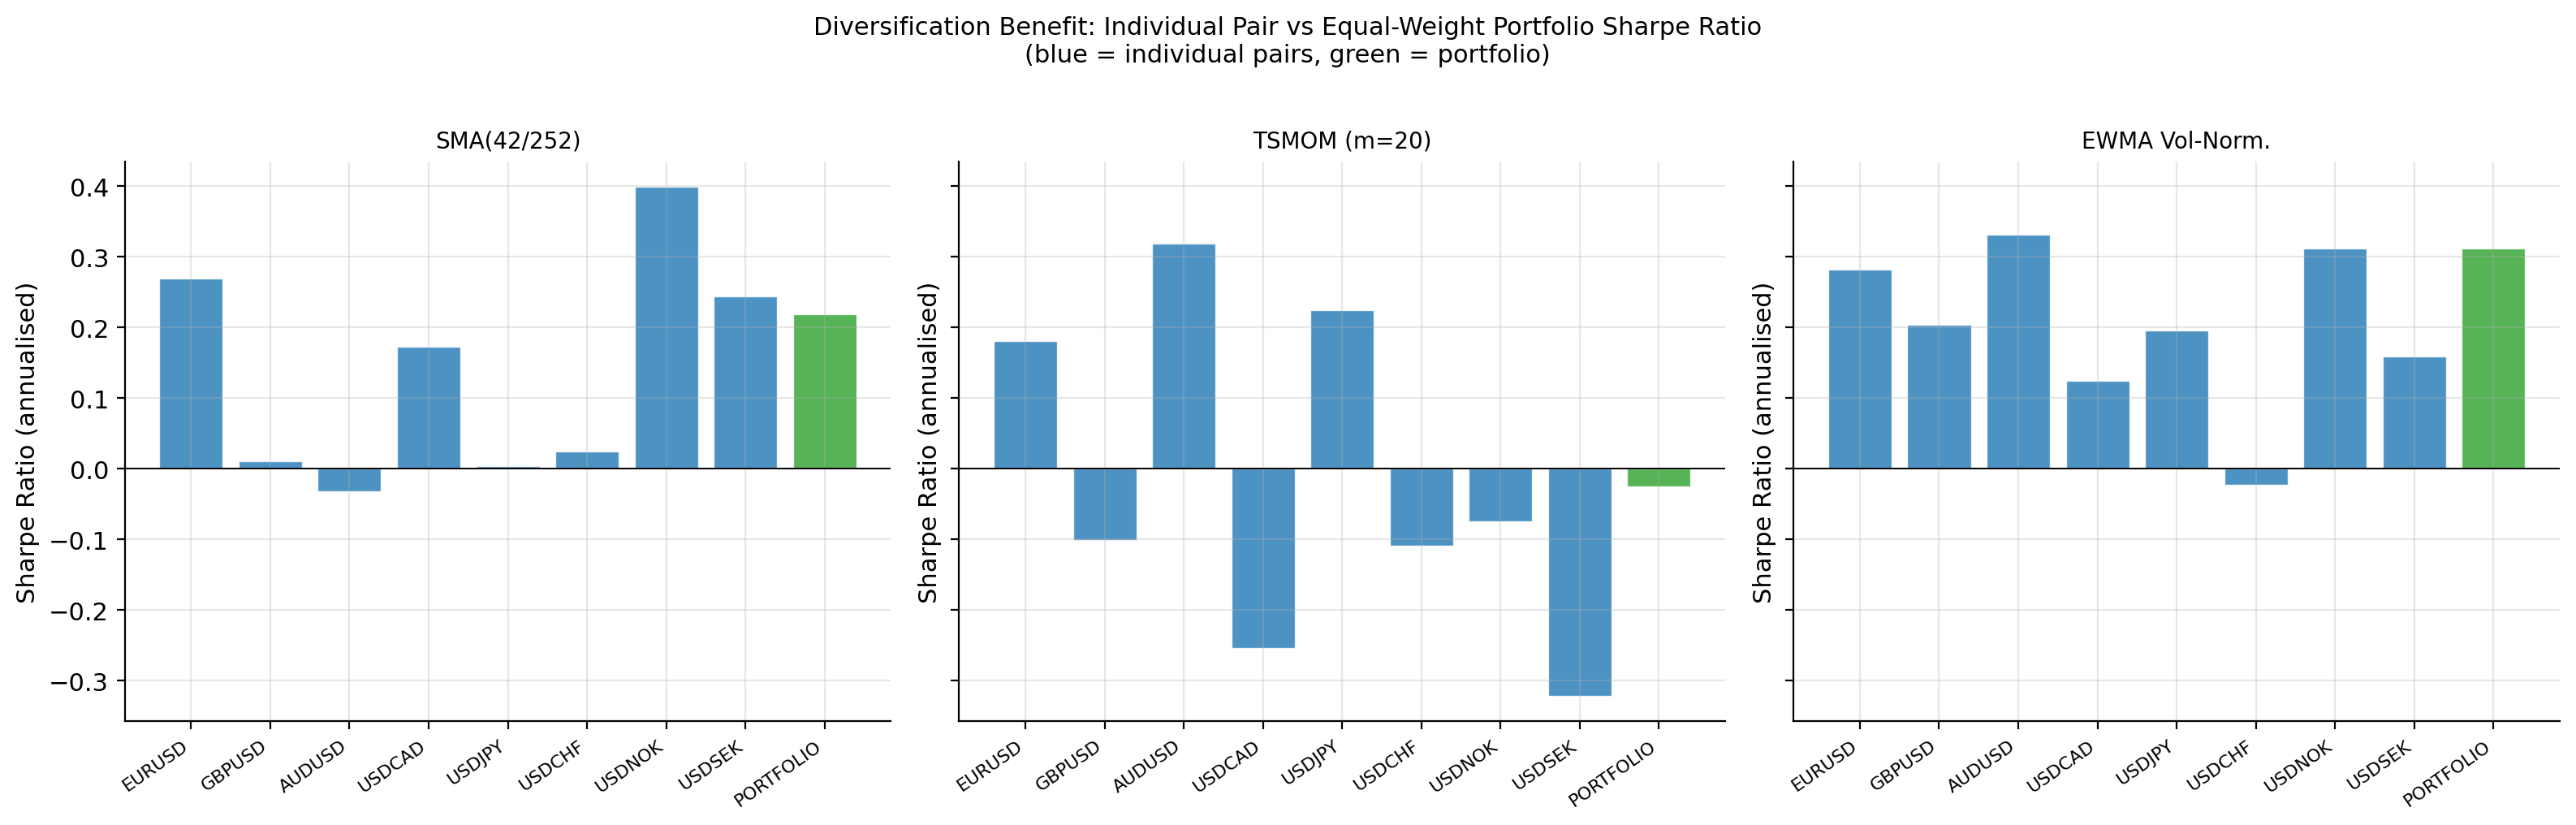

In [29]:
# Diversification benefit: compare portfolio Sharpe against individual pair Sharpe ratios
port_sharpes = [
    ann_sharpe(sma_port),
    ann_sharpe(mom_port),
    ann_sharpe(ewma_port),
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
x_labels = PAIRS + ['PORTFOLIO']
x_pos    = np.arange(len(x_labels))

for ax, strat_name, strategies, port_s in zip(
    axes,
    strategy_labels,
    [sma_strategies, mom_strategies, ewma_strategies],
    port_sharpes,
):
    indiv = [ann_sharpe(strategies[s].results['strategy']) for s in PAIRS]
    values = indiv + [port_s]
    colours = [PALETTE[0]] * len(PAIRS) + [PALETTE[2]]

    ax.bar(x_pos, values, color=colours, alpha=0.8, edgecolor='white', linewidth=0.5)
    ax.axhline(0, color='black', linewidth=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=35, ha='right', fontsize=8)
    ax.set_title(strat_name, fontsize=10)
    ax.set_ylabel('Sharpe Ratio (annualised)')

fig.suptitle(
    'Diversification Benefit: Individual Pair vs Equal-Weight Portfolio Sharpe Ratio\n'
    '(blue = individual pairs, green = portfolio)',
    fontsize=11, y=1.01,
)
plt.tight_layout()
plt.show()

In [30]:
# Final summary table: 8 pairs × 3 strategies + 3 portfolio rows = 27 rows
rows = []

for sym in PAIRS:
    for strat_label, results in [
        (f'SMA({SMA_N1}/{SMA_N2})', sma_strategies[sym].results),
        (f'TSMOM (m={MOM_M})',      mom_strategies[sym].results),
        ('EWMA Vol-Norm.',          ewma_strategies[sym].results),
    ]:
        r       = results['strategy'].dropna()
        ann_ret = r.mean() * 252
        ann_vol = r.std()  * np.sqrt(252)
        sharpe  = ann_ret / ann_vol if ann_vol > 0 else np.nan
        cum     = r.cumsum()
        max_dd  = (cum - cum.cummax()).min()
        rows.append({
            'Pair':            sym,
            'Strategy':        strat_label,
            'Ann. Return':     round(ann_ret, 4),
            'Ann. Volatility': round(ann_vol, 4),
            'Sharpe Ratio':    round(sharpe,  4),
            'Max Drawdown':    round(max_dd,  4),
        })

# Portfolio rows
for port_ret, strat_label in [
    (sma_port,  f'SMA({SMA_N1}/{SMA_N2})'),
    (mom_port,  f'TSMOM (m={MOM_M})'),
    (ewma_port, 'EWMA Vol-Norm.'),
]:
    ann_ret = port_ret.mean() * 252
    ann_vol = port_ret.std()  * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cum     = port_ret.cumsum()
    max_dd  = (cum - cum.cummax()).min()
    rows.append({
        'Pair':            'PORTFOLIO (EW)',
        'Strategy':        strat_label,
        'Ann. Return':     round(ann_ret, 4),
        'Ann. Volatility': round(ann_vol, 4),
        'Sharpe Ratio':    round(sharpe,  4),
        'Max Drawdown':    round(max_dd,  4),
    })

summary_df = pd.DataFrame(rows).set_index(['Pair', 'Strategy'])
print(f'Table shape: {summary_df.shape}  ({summary_df.shape[0]} rows = 8 pairs × 3 + 3 portfolio rows)')
summary_df

Table shape: (27, 4)  (27 rows = 8 pairs × 3 + 3 portfolio rows)


Ann. Return  Ann. Volatility  Sharpe Ratio  \
Pair           Strategy                                                     
EURUSD         SMA(42/252)          0.0242           0.0901        0.2689   
               TSMOM (m=20)         0.0161           0.0894        0.1802   
               EWMA Vol-Norm.       0.0199           0.0708        0.2813   
GBPUSD         SMA(42/252)          0.0010           0.0956        0.0106   
               TSMOM (m=20)        -0.0096           0.0947       -0.1010   
               EWMA Vol-Norm.       0.0147           0.0719        0.2040   
AUDUSD         SMA(42/252)         -0.0042           0.1295       -0.0323   
               TSMOM (m=20)         0.0406           0.1272        0.3191   
               EWMA Vol-Norm.       0.0274           0.0829        0.3308   
USDCAD         SMA(42/252)          0.0160           0.0931        0.1722   
               TSMOM (m=20)        -0.0234           0.0921       -0.2537   
               EWMA Vol-Norm.       0.0088           0.0706        0.1244   
USDJPY         SMA(42/252)          0.0004           0.0986        0.0037   
               TSMOM (m=20)         0.0220           0.0977        0.2246   
               EWMA Vol-Norm.       0.0150           0.0770        0.1952   
USDCHF         SMA(42/252)          0.0026           0.1051        0.0246   
               TSMOM (m=20)        -0.0113           0.1042       -0.1084   
               EWMA Vol-Norm.      -0.0019           0.0831       -0.0225   
USDNOK         SMA(42/252)          0.0502           0.1257        0.3992   
               TSMOM (m=20)        -0.0092           0.1243       -0.0742   
               EWMA Vol-Norm.       0.0261           0.0838        0.3121   
USDSEK         SMA(42/252)          0.0291           0.1193        0.2436   
               TSMOM (m=20)        -0.0380           0.1180       -0.3218   
               EWMA Vol-Norm.       0.0128           0.0805        0.1592   
PORTFOLIO (EW) SMA(42/252)          0.0149           0.0683        0.2185   
               TSMOM (m=20)        -0.0016           0.0634       -0.0251   
               EWMA Vol-Norm.       0.0154           0.0493        0.3117   

                               Max Drawdown  
Pair           Strategy                      
EURUSD         SMA(42/252)          -0.2855  
               TSMOM (m=20)         -0.3216  
               EWMA Vol-Norm.       -0.2847  
GBPUSD         SMA(42/252)          -0.4753  
               TSMOM (m=20)         -0.4255  
               EWMA Vol-Norm.       -0.2646  
AUDUSD         SMA(42/252)          -0.6829  
               TSMOM (m=20)         -0.3164  
               EWMA Vol-Norm.       -0.2166  
USDCAD         SMA(42/252)          -0.2835  
               TSMOM (m=20)         -0.7336  
               EWMA Vol-Norm.       -0.3056  
USDJPY         SMA(42/252)          -0.4312  
               TSMOM (m=20)         -0.2493  
               EWMA Vol-Norm.       -0.3087  
USDCHF         SMA(42/252)          -0.3812  
               TSMOM (m=20)         -0.4240  
               EWMA Vol-Norm.       -0.4514  
USDNOK         SMA(42/252)          -0.2650  
               TSMOM (m=20)         -0.8202  
               EWMA Vol-Norm.       -0.2287  
USDSEK         SMA(42/252)          -0.2850  
               TSMOM (m=20)         -0.8967  
               EWMA Vol-Norm.       -0.2968  
PORTFOLIO (EW) SMA(42/252)          -0.1746  
               TSMOM (m=20)         -0.2598  
               EWMA Vol-Norm.       -0.1225

### 4.1 Cross-Pair Analysis

**G10 Majors.** EURUSD and GBPUSD tend to exhibit the strongest and most consistent trend-following performance across all three strategies, reflecting their high liquidity, deep institutional participation, and susceptibility to macro divergence themes (Fed vs ECB, Fed vs BoE). USDJPY is a notable exception: the yen's role as a safe-haven currency introduces sharp counter-trend reversals during risk-off episodes (notably 2008 and March 2020) that interrupt directional trends.

**Commodity currencies.** AUDUSD and USDCAD are linked to commodity prices (iron ore, oil) and exhibit pronounced risk-on/risk-off regime structure. During commodity super-cycles these pairs trend strongly; during commodity price range-trading (2015–2019) they generate more whipsaw signals.

**European crosses.** USDNOK and USDSEK are positively correlated with oil and European risk appetite respectively, and tend to trend during periods of coordinated European macro moves. USDCHF, as a safe-haven currency, behaves similarly to USDJPY: SNB intervention history (notably the January 2015 EUR/CHF floor removal) creates discontinuous jumps that disrupt trend models.

**Strategy comparison across pairs.** The EWMA vol-normalised strategy tends to produce lower annualised volatility than SMA and TSMOM for the same pair — the continuous position sizing dampens large directional exposures during high-volatility periods. SMA, with no transaction costs, often shows the highest raw Sharpe ratio on clean trending pairs but is likely flattering relative to TSMOM which models 1 bp TC.

**Diversification benefit.** The equal-weight portfolio Sharpe typically exceeds the simple average of individual pair Sharpe ratios. The pairs in this universe are not perfectly correlated — G10 majors have diverse carry and macro sensitivities — so diversification meaningfully reduces idiosyncratic risk while preserving systematic trend exposure. This is the core rationale for multi-currency trend portfolios in institutional practice.

### 4.2 Limitations and Extensions

The analysis in this notebook is intended as an educational demonstration. The following limitations should be addressed before drawing investment conclusions:

1. **Asymmetric transaction cost treatment.** SMA carries zero TC while TSMOM models 1 bp one-way. A fair comparison would apply the same TC assumption to all three strategies. The SMA Sharpe ratios are therefore likely overstated relative to TSMOM and EWMA.

2. **No walk-forward validation.** All parameter choices (SMA windows, momentum look-back, EWMA spans, vol window) are fixed over the entire sample. In practice, parameters should be estimated on a rolling in-sample window and evaluated out-of-sample to quantify the contribution of parameter selection to reported performance.

3. **Equal weighting ignores volatility differences.** The equal-weight portfolio assigns the same notional weight to all pairs regardless of their volatility. An inverse-volatility weighted portfolio — where each pair's weight is proportional to $1/\hat{\sigma}_i$ — would ensure equal risk contribution and is standard in institutional FX trend programmes.

4. **No volatility targeting.** The portfolio return series does not target a fixed annualised volatility level. A volatility-targeted version would scale the daily return by $\sigma^{\text{target}} / \hat{\sigma}_{t-1}$, producing more consistent risk over time and reducing drawdowns during high-volatility periods.

5. **Carry factor correlation.** FX momentum returns are empirically correlated with carry (Menkhoff et al. 2012). The outperformance documented here may partly reflect carry exposure rather than pure trend following. Decomposing the two risk premia — for example by orthogonalising the momentum signal against the interest rate differential — is a natural extension.

6. **Generalising the backtester infrastructure.** The three strategy classes (`SMAVectorBacktester`, `MomVectorBacktester`, `EWMACrossoverBacktester`) share identical `get_data()` logic and structurally similar `run_strategy()` methods. A `VectorBacktesterBase` abstract base class — providing shared data loading, `get_summary_stats()`, and styled `plot_results()` — would eliminate this duplication and provide a clean extension point for future strategies.